# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    intermediate_output_layer = bilinear_upsample((2,2))(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    skip_output_layer = layers.concatenate([large_ip_layer, intermediate_output_layer])
    # TODO Add some number of separable convolution layers
    output_layer_next = separable_conv2d_batchnorm(skip_output_layer, filters, 1)
    output_layer = separable_conv2d_batchnorm(output_layer_next, filters, 1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder1 = encoder_block(inputs, 32, 2);
    encoder2 = encoder_block(encoder1, 64, 2);
    encoder3 = encoder_block(encoder2, 128, 2);
    #encoder4 = encoder_block(encoder3, 256, 2);
    #encoder5 = encoder_block(encoder4, 512, 2);
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_layer = conv2d_batchnorm(encoder3, 128, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #decoder1 = decoder_block(onebyone_layer, encoder4, 512)
    #decoder2 = decoder_block(onebyone_layer, encoder3, 256)
    decoder3 = decoder_block(onebyone_layer, encoder2, 128)
    decoder4 = decoder_block(decoder3, encoder1, 64)
    decoder5 = decoder_block(decoder4, inputs, 32)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decoder5)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 100
num_epochs = 250
steps_per_epoch = 75
validation_steps = 15
workers = 2

Epoch 1/250
74/75 [============================>.] - ETA: 1s - loss: 0.7107

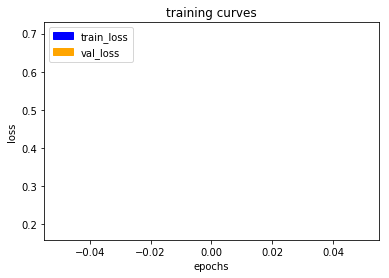

75/75 [==============================] - 146s - loss: 0.7034 - val_loss: 0.1854
Epoch 2/250
74/75 [============================>.] - ETA: 1s - loss: 0.0852

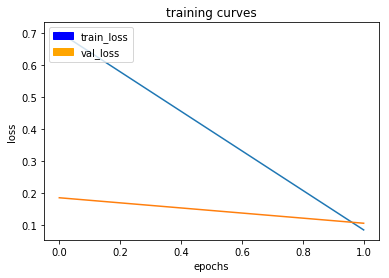

75/75 [==============================] - 136s - loss: 0.0849 - val_loss: 0.1057
Epoch 3/250
74/75 [============================>.] - ETA: 1s - loss: 0.0522

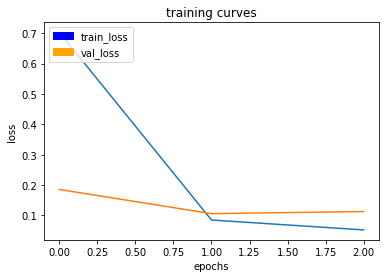

75/75 [==============================] - 137s - loss: 0.0521 - val_loss: 0.1127
Epoch 4/250
74/75 [============================>.] - ETA: 1s - loss: 0.0446

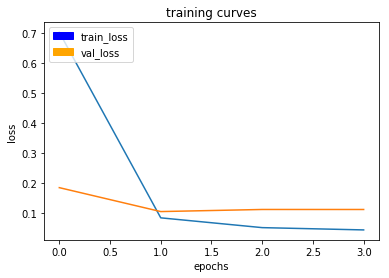

75/75 [==============================] - 136s - loss: 0.0447 - val_loss: 0.1126
Epoch 5/250
74/75 [============================>.] - ETA: 1s - loss: 0.0476

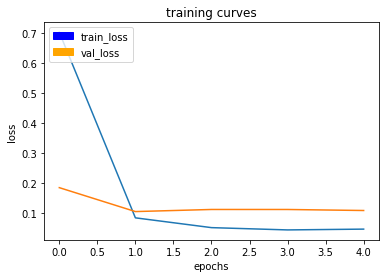

75/75 [==============================] - 137s - loss: 0.0475 - val_loss: 0.1092
Epoch 6/250
74/75 [============================>.] - ETA: 1s - loss: 0.0379

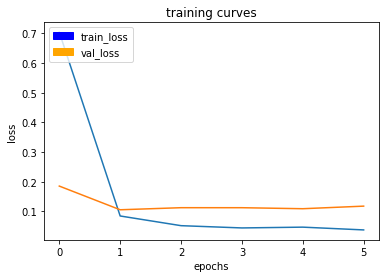

75/75 [==============================] - 137s - loss: 0.0379 - val_loss: 0.1179
Epoch 7/250
74/75 [============================>.] - ETA: 1s - loss: 0.0380

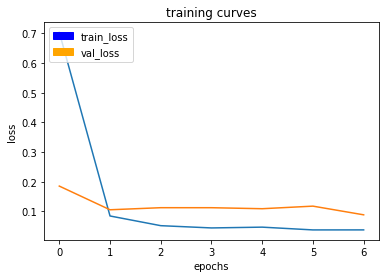

75/75 [==============================] - 137s - loss: 0.0380 - val_loss: 0.0887
Epoch 8/250
74/75 [============================>.] - ETA: 1s - loss: 0.0335

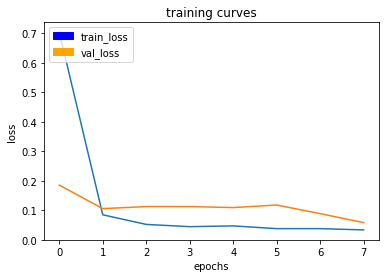

75/75 [==============================] - 137s - loss: 0.0334 - val_loss: 0.0584
Epoch 9/250
74/75 [============================>.] - ETA: 1s - loss: 0.0310

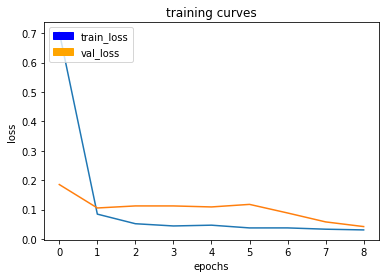

75/75 [==============================] - 137s - loss: 0.0310 - val_loss: 0.0424
Epoch 10/250
74/75 [============================>.] - ETA: 1s - loss: 0.0298

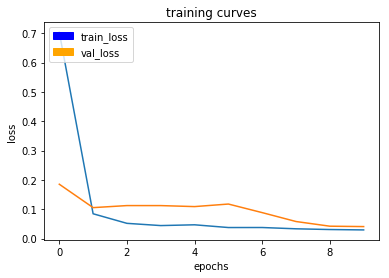

75/75 [==============================] - 137s - loss: 0.0297 - val_loss: 0.0411
Epoch 11/250
74/75 [============================>.] - ETA: 1s - loss: 0.0295

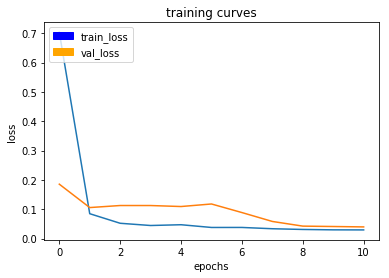

75/75 [==============================] - 137s - loss: 0.0294 - val_loss: 0.0397
Epoch 12/250
74/75 [============================>.] - ETA: 1s - loss: 0.0267

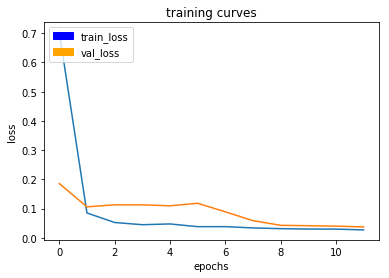

75/75 [==============================] - 137s - loss: 0.0267 - val_loss: 0.0369
Epoch 13/250
74/75 [============================>.] - ETA: 1s - loss: 0.0262

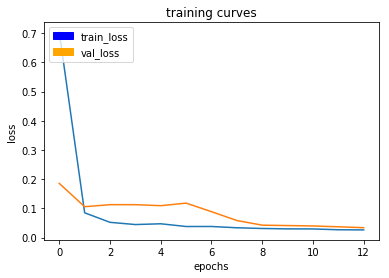

75/75 [==============================] - 137s - loss: 0.0261 - val_loss: 0.0338
Epoch 14/250
74/75 [============================>.] - ETA: 1s - loss: 0.0246

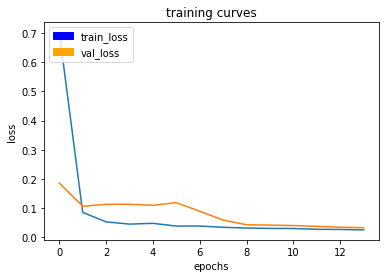

75/75 [==============================] - 137s - loss: 0.0247 - val_loss: 0.0323
Epoch 15/250
74/75 [============================>.] - ETA: 1s - loss: 0.0253

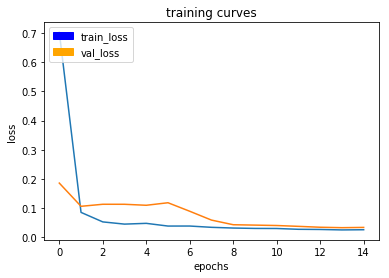

75/75 [==============================] - 138s - loss: 0.0253 - val_loss: 0.0332
Epoch 16/250
74/75 [============================>.] - ETA: 1s - loss: 0.0242

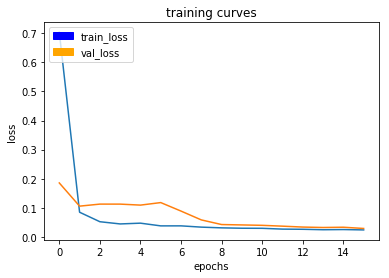

75/75 [==============================] - 136s - loss: 0.0242 - val_loss: 0.0290
Epoch 17/250
74/75 [============================>.] - ETA: 1s - loss: 0.0223

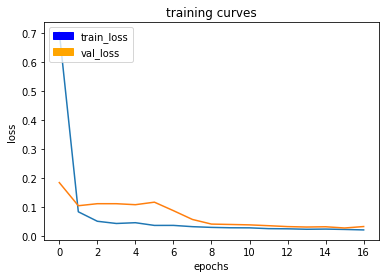

75/75 [==============================] - 136s - loss: 0.0223 - val_loss: 0.0340
Epoch 18/250
74/75 [============================>.] - ETA: 1s - loss: 0.0221

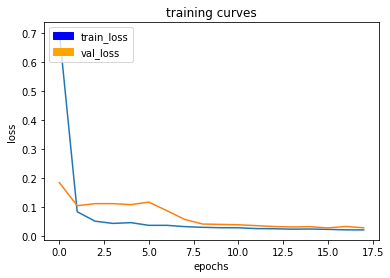

75/75 [==============================] - 137s - loss: 0.0221 - val_loss: 0.0295
Epoch 19/250
74/75 [============================>.] - ETA: 1s - loss: 0.0221

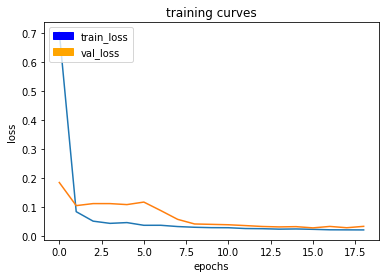

75/75 [==============================] - 138s - loss: 0.0221 - val_loss: 0.0342
Epoch 20/250
74/75 [============================>.] - ETA: 1s - loss: 0.0220

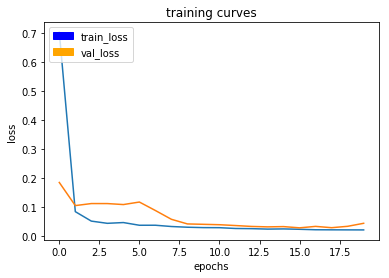

75/75 [==============================] - 136s - loss: 0.0219 - val_loss: 0.0446
Epoch 21/250
74/75 [============================>.] - ETA: 1s - loss: 0.0209

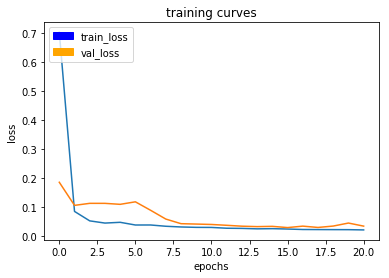

75/75 [==============================] - 137s - loss: 0.0208 - val_loss: 0.0340
Epoch 22/250
74/75 [============================>.] - ETA: 1s - loss: 0.0205

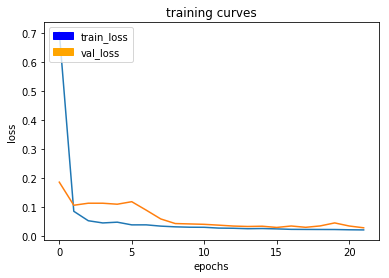

75/75 [==============================] - 136s - loss: 0.0204 - val_loss: 0.0277
Epoch 23/250
74/75 [============================>.] - ETA: 1s - loss: 0.0197

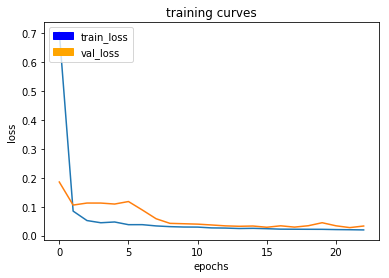

75/75 [==============================] - 137s - loss: 0.0197 - val_loss: 0.0332
Epoch 24/250
74/75 [============================>.] - ETA: 1s - loss: 0.0194

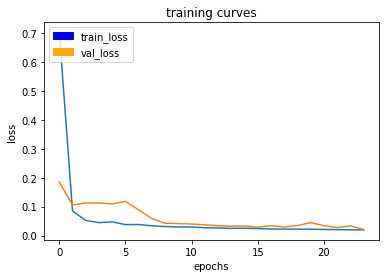

75/75 [==============================] - 138s - loss: 0.0194 - val_loss: 0.0211
Epoch 25/250
74/75 [============================>.] - ETA: 1s - loss: 0.0183

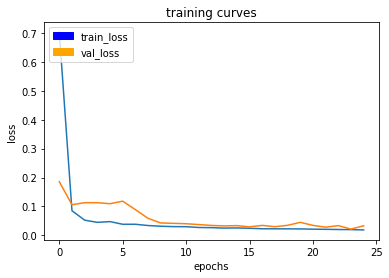

75/75 [==============================] - 136s - loss: 0.0183 - val_loss: 0.0328
Epoch 26/250
74/75 [============================>.] - ETA: 1s - loss: 0.0189

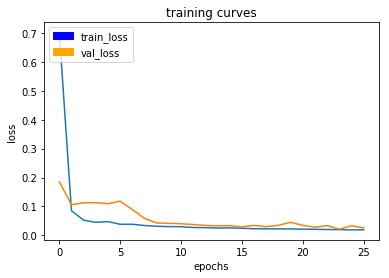

75/75 [==============================] - 137s - loss: 0.0189 - val_loss: 0.0253
Epoch 27/250
74/75 [============================>.] - ETA: 1s - loss: 0.0178

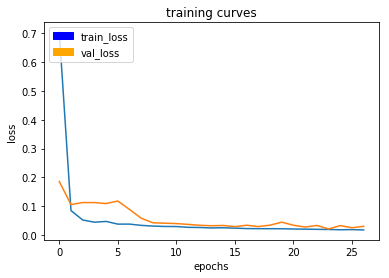

75/75 [==============================] - 137s - loss: 0.0178 - val_loss: 0.0302
Epoch 28/250
74/75 [============================>.] - ETA: 1s - loss: 0.0177

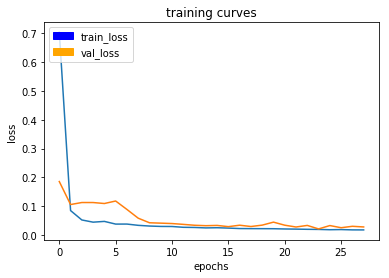

75/75 [==============================] - 137s - loss: 0.0177 - val_loss: 0.0279
Epoch 29/250
74/75 [============================>.] - ETA: 1s - loss: 0.0190

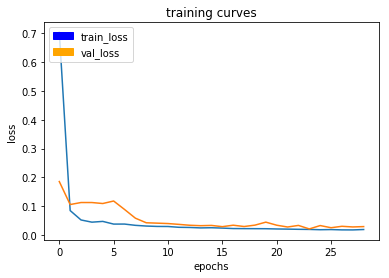

75/75 [==============================] - 137s - loss: 0.0190 - val_loss: 0.0292
Epoch 30/250
74/75 [============================>.] - ETA: 1s - loss: 0.0170

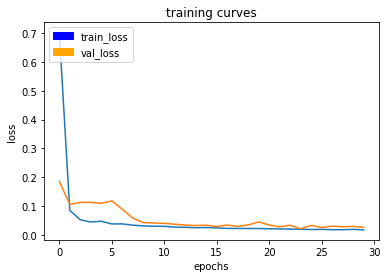

75/75 [==============================] - 137s - loss: 0.0170 - val_loss: 0.0259
Epoch 31/250
74/75 [============================>.] - ETA: 1s - loss: 0.0213

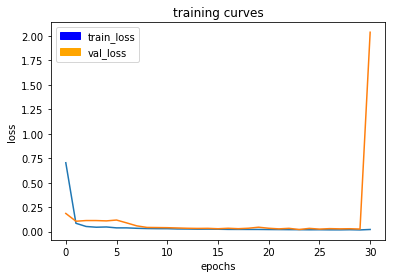

75/75 [==============================] - 136s - loss: 0.0216 - val_loss: 2.0376
Epoch 32/250
74/75 [============================>.] - ETA: 1s - loss: 0.0299

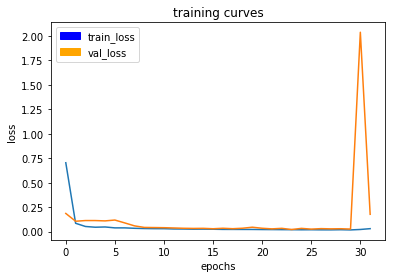

75/75 [==============================] - 137s - loss: 0.0298 - val_loss: 0.1766
Epoch 33/250
74/75 [============================>.] - ETA: 1s - loss: 0.0239

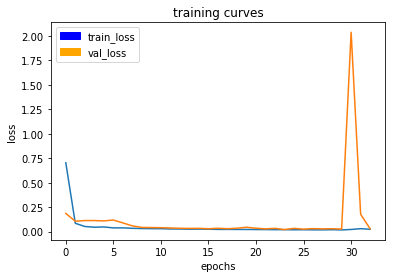

75/75 [==============================] - 138s - loss: 0.0239 - val_loss: 0.0282
Epoch 34/250
74/75 [============================>.] - ETA: 1s - loss: 0.0210

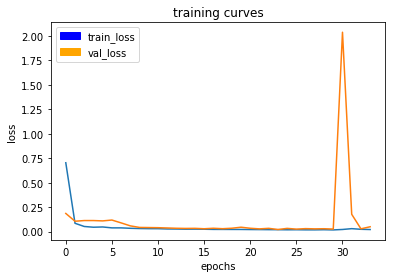

75/75 [==============================] - 137s - loss: 0.0211 - val_loss: 0.0492
Epoch 35/250
74/75 [============================>.] - ETA: 1s - loss: 0.0211

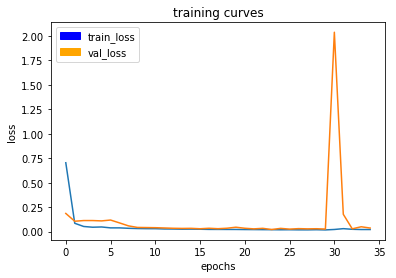

75/75 [==============================] - 137s - loss: 0.0211 - val_loss: 0.0361
Epoch 36/250
74/75 [============================>.] - ETA: 1s - loss: 0.0195

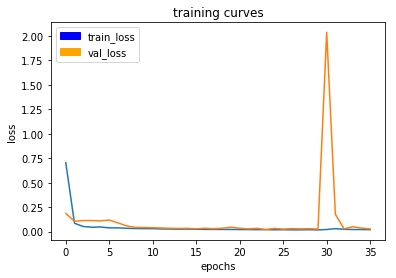

75/75 [==============================] - 137s - loss: 0.0194 - val_loss: 0.0274
Epoch 37/250
74/75 [============================>.] - ETA: 1s - loss: 0.0176

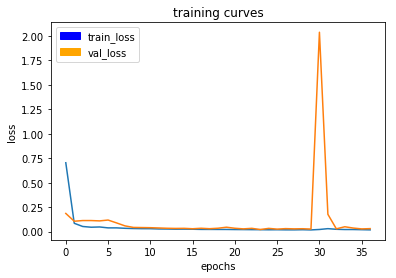

75/75 [==============================] - 137s - loss: 0.0176 - val_loss: 0.0303
Epoch 38/250
74/75 [============================>.] - ETA: 1s - loss: 0.0184

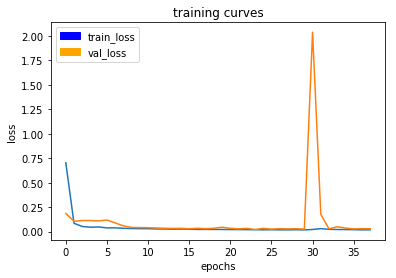

75/75 [==============================] - 138s - loss: 0.0184 - val_loss: 0.0288
Epoch 39/250
74/75 [============================>.] - ETA: 1s - loss: 0.0174

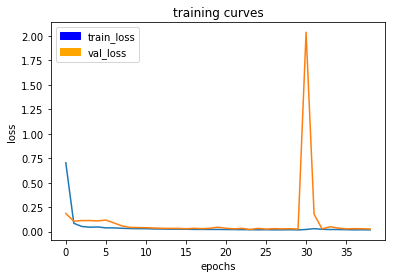

75/75 [==============================] - 136s - loss: 0.0173 - val_loss: 0.0266
Epoch 40/250
74/75 [============================>.] - ETA: 1s - loss: 0.0161

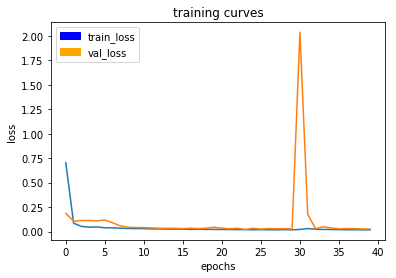

75/75 [==============================] - 137s - loss: 0.0164 - val_loss: 0.0254
Epoch 41/250
74/75 [============================>.] - ETA: 1s - loss: 0.0180

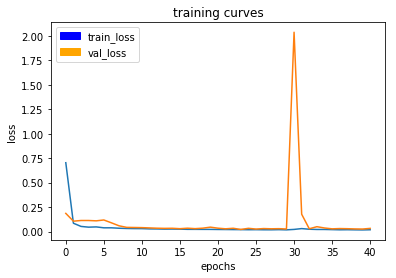

75/75 [==============================] - 137s - loss: 0.0180 - val_loss: 0.0321
Epoch 42/250
74/75 [============================>.] - ETA: 1s - loss: 0.0157

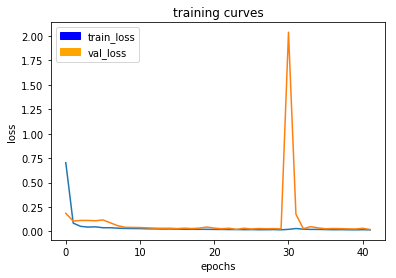

75/75 [==============================] - 137s - loss: 0.0157 - val_loss: 0.0198
Epoch 43/250
74/75 [============================>.] - ETA: 1s - loss: 0.0154

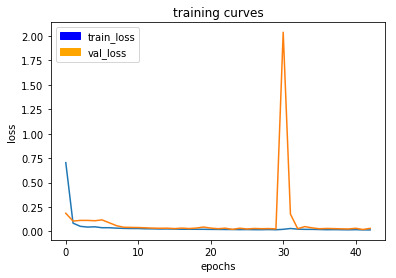

75/75 [==============================] - 138s - loss: 0.0154 - val_loss: 0.0314
Epoch 44/250
74/75 [============================>.] - ETA: 1s - loss: 0.0154

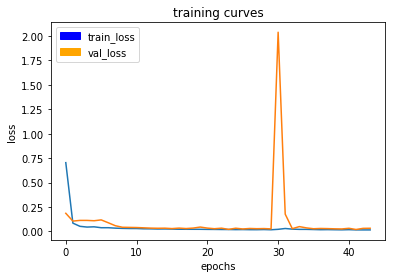

75/75 [==============================] - 137s - loss: 0.0154 - val_loss: 0.0323
Epoch 45/250
74/75 [============================>.] - ETA: 1s - loss: 0.0154

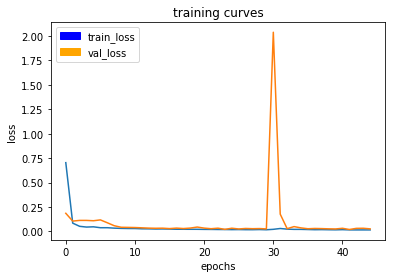

75/75 [==============================] - 136s - loss: 0.0154 - val_loss: 0.0263
Epoch 46/250
74/75 [============================>.] - ETA: 1s - loss: 0.0152

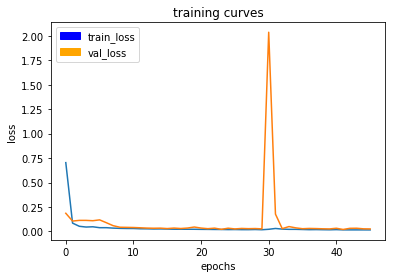

75/75 [==============================] - 137s - loss: 0.0152 - val_loss: 0.0253
Epoch 47/250
74/75 [============================>.] - ETA: 1s - loss: 0.0150

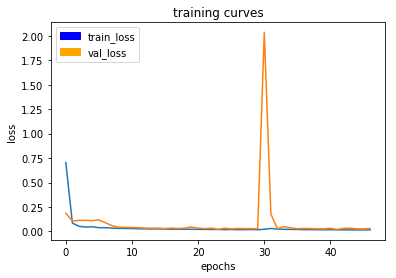

75/75 [==============================] - 138s - loss: 0.0150 - val_loss: 0.0300
Epoch 48/250
74/75 [============================>.] - ETA: 1s - loss: 0.0143

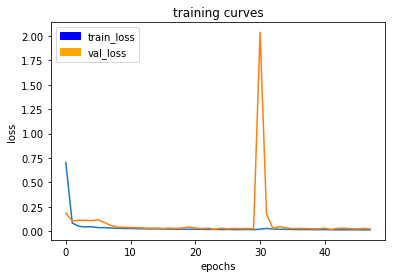

75/75 [==============================] - 136s - loss: 0.0144 - val_loss: 0.0250
Epoch 49/250
74/75 [============================>.] - ETA: 1s - loss: 0.0142

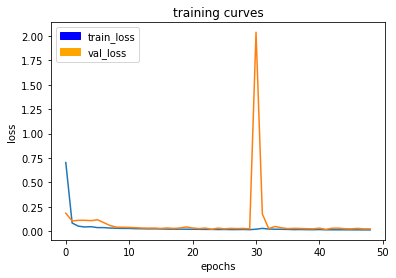

75/75 [==============================] - 136s - loss: 0.0142 - val_loss: 0.0252
Epoch 50/250
74/75 [============================>.] - ETA: 1s - loss: 0.0138

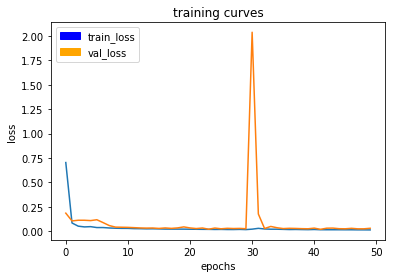

75/75 [==============================] - 136s - loss: 0.0138 - val_loss: 0.0305
Epoch 51/250
74/75 [============================>.] - ETA: 1s - loss: 0.0139

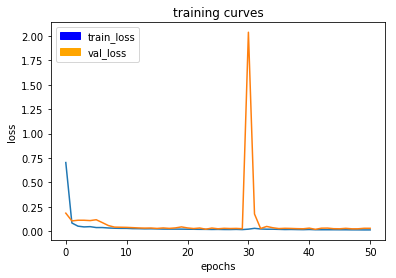

75/75 [==============================] - 136s - loss: 0.0139 - val_loss: 0.0303
Epoch 52/250
74/75 [============================>.] - ETA: 1s - loss: 0.0144

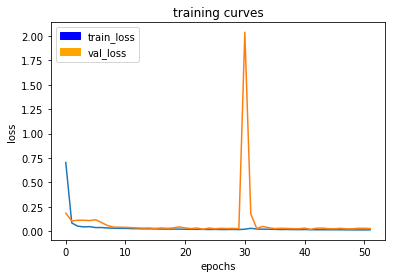

75/75 [==============================] - 139s - loss: 0.0145 - val_loss: 0.0278
Epoch 53/250
74/75 [============================>.] - ETA: 1s - loss: 0.0150

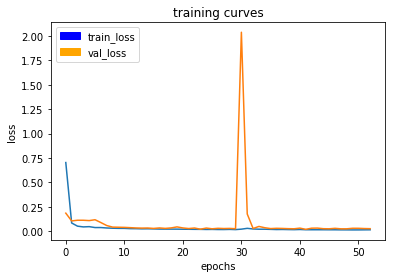

75/75 [==============================] - 137s - loss: 0.0150 - val_loss: 0.0264
Epoch 54/250
74/75 [============================>.] - ETA: 1s - loss: 0.0139

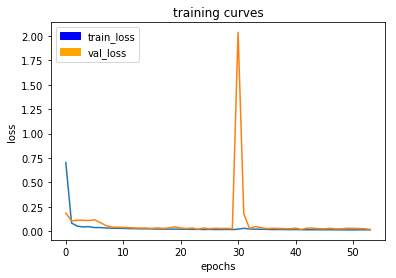

75/75 [==============================] - 136s - loss: 0.0139 - val_loss: 0.0195
Epoch 55/250
74/75 [============================>.] - ETA: 1s - loss: 0.0144

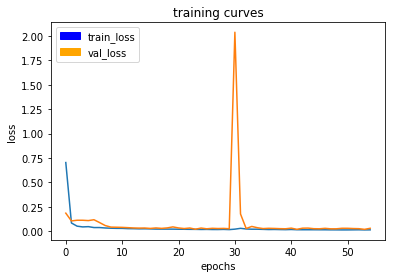

75/75 [==============================] - 136s - loss: 0.0143 - val_loss: 0.0303
Epoch 56/250
74/75 [============================>.] - ETA: 1s - loss: 0.0144

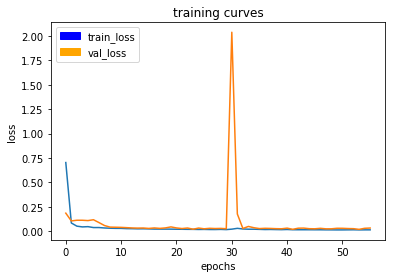

75/75 [==============================] - 137s - loss: 0.0144 - val_loss: 0.0329
Epoch 57/250
74/75 [============================>.] - ETA: 1s - loss: 0.0132

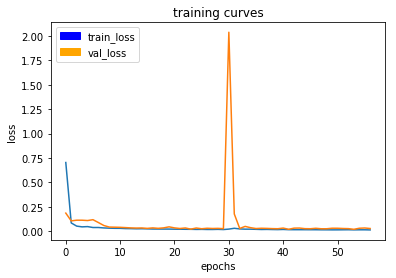

75/75 [==============================] - 138s - loss: 0.0132 - val_loss: 0.0275
Epoch 58/250
74/75 [============================>.] - ETA: 1s - loss: 0.0129

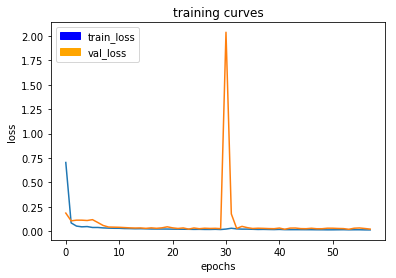

75/75 [==============================] - 136s - loss: 0.0129 - val_loss: 0.0213
Epoch 59/250
74/75 [============================>.] - ETA: 1s - loss: 0.0129

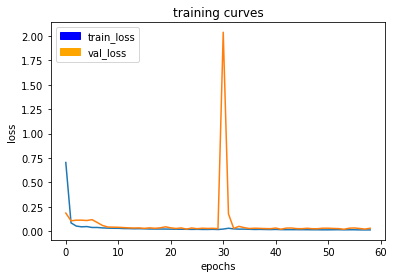

75/75 [==============================] - 137s - loss: 0.0129 - val_loss: 0.0300
Epoch 60/250
74/75 [============================>.] - ETA: 1s - loss: 0.0125

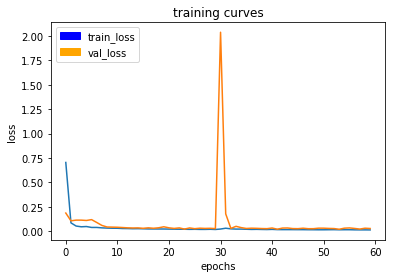

75/75 [==============================] - 137s - loss: 0.0125 - val_loss: 0.0269
Epoch 61/250
74/75 [============================>.] - ETA: 1s - loss: 0.0126

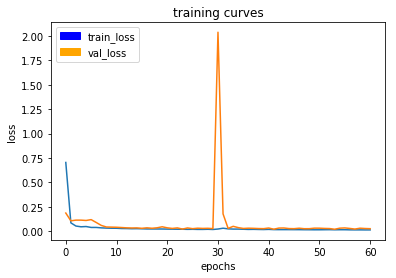

75/75 [==============================] - 137s - loss: 0.0126 - val_loss: 0.0252
Epoch 62/250
74/75 [============================>.] - ETA: 1s - loss: 0.0124

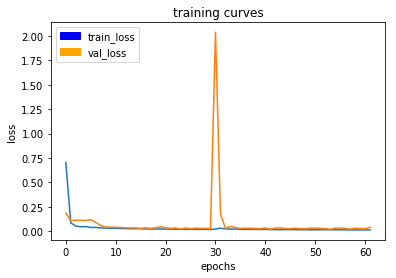

75/75 [==============================] - 137s - loss: 0.0125 - val_loss: 0.0396
Epoch 63/250
74/75 [============================>.] - ETA: 1s - loss: 0.0144

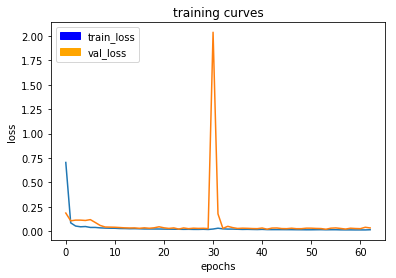

75/75 [==============================] - 137s - loss: 0.0144 - val_loss: 0.0328
Epoch 64/250
74/75 [============================>.] - ETA: 1s - loss: 0.0164

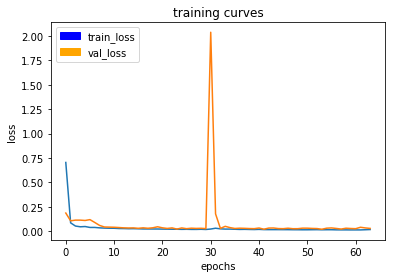

75/75 [==============================] - 137s - loss: 0.0164 - val_loss: 0.0278
Epoch 65/250
74/75 [============================>.] - ETA: 1s - loss: 0.0136

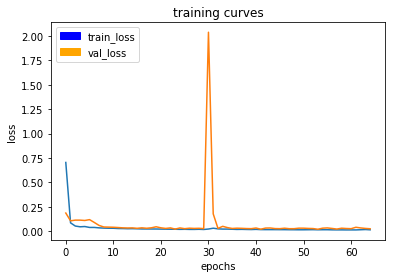

75/75 [==============================] - 136s - loss: 0.0137 - val_loss: 0.0244
Epoch 66/250
74/75 [============================>.] - ETA: 1s - loss: 0.0124

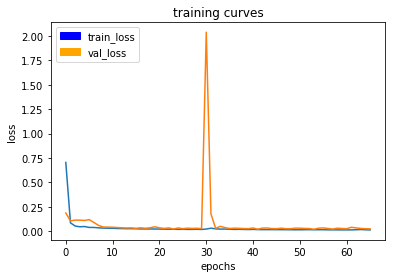

75/75 [==============================] - 138s - loss: 0.0124 - val_loss: 0.0236
Epoch 67/250
74/75 [============================>.] - ETA: 1s - loss: 0.0122

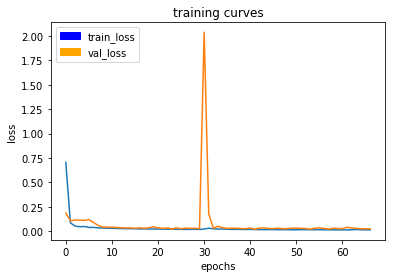

75/75 [==============================] - 136s - loss: 0.0122 - val_loss: 0.0243
Epoch 68/250
74/75 [============================>.] - ETA: 1s - loss: 0.0126

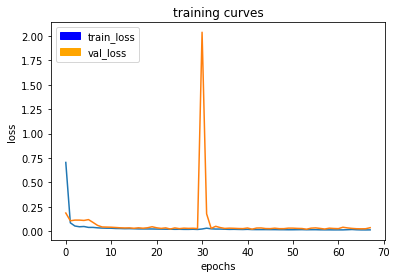

75/75 [==============================] - 137s - loss: 0.0126 - val_loss: 0.0348
Epoch 69/250
74/75 [============================>.] - ETA: 1s - loss: 0.0121

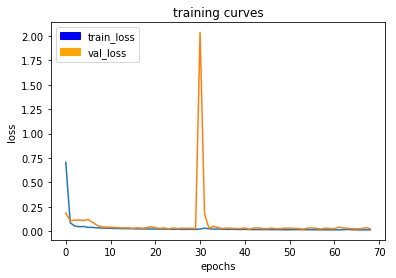

75/75 [==============================] - 137s - loss: 0.0121 - val_loss: 0.0252
Epoch 70/250
74/75 [============================>.] - ETA: 1s - loss: 0.0118

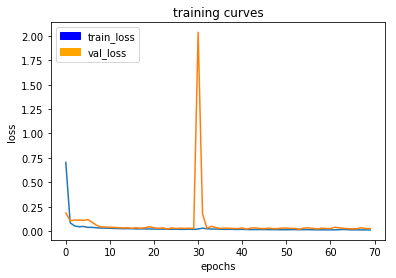

75/75 [==============================] - 137s - loss: 0.0118 - val_loss: 0.0254
Epoch 71/250
74/75 [============================>.] - ETA: 1s - loss: 0.0116

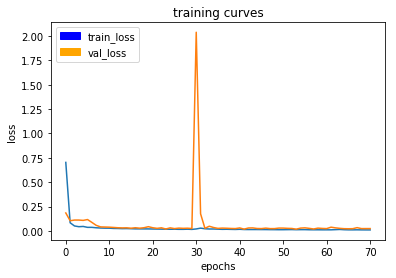

75/75 [==============================] - 138s - loss: 0.0116 - val_loss: 0.0254
Epoch 72/250
74/75 [============================>.] - ETA: 1s - loss: 0.0116

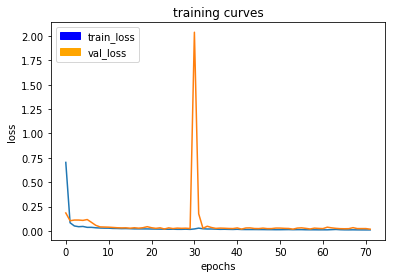

75/75 [==============================] - 136s - loss: 0.0116 - val_loss: 0.0192
Epoch 73/250
74/75 [============================>.] - ETA: 1s - loss: 0.0116

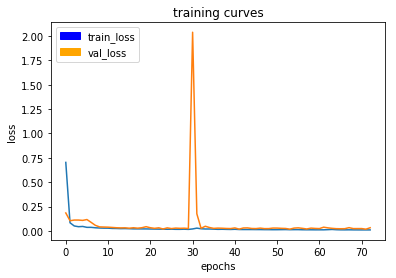

75/75 [==============================] - 136s - loss: 0.0116 - val_loss: 0.0338
Epoch 74/250
74/75 [============================>.] - ETA: 1s - loss: 0.0114

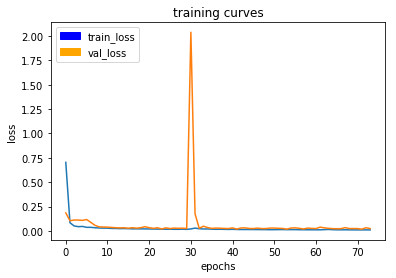

75/75 [==============================] - 136s - loss: 0.0114 - val_loss: 0.0252
Epoch 75/250
74/75 [============================>.] - ETA: 1s - loss: 0.0112

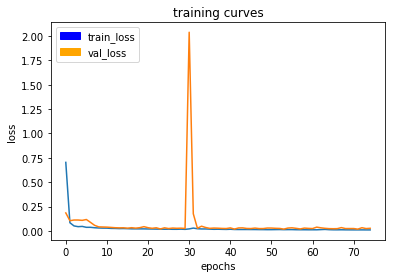

75/75 [==============================] - 137s - loss: 0.0112 - val_loss: 0.0278
Epoch 76/250
74/75 [============================>.] - ETA: 1s - loss: 0.0110

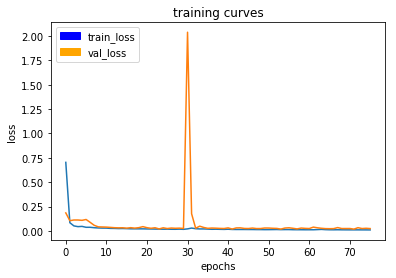

75/75 [==============================] - 137s - loss: 0.0110 - val_loss: 0.0247
Epoch 77/250
74/75 [============================>.] - ETA: 1s - loss: 0.0110

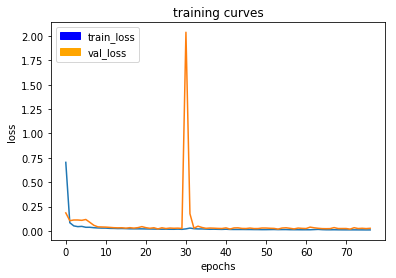

75/75 [==============================] - 136s - loss: 0.0110 - val_loss: 0.0276
Epoch 78/250
74/75 [============================>.] - ETA: 1s - loss: 0.0151

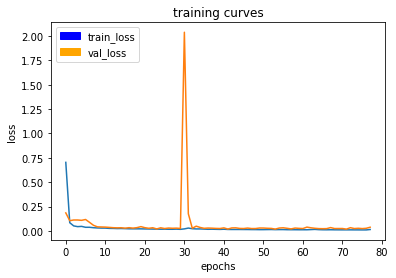

75/75 [==============================] - 136s - loss: 0.0151 - val_loss: 0.0384
Epoch 79/250
74/75 [============================>.] - ETA: 1s - loss: 0.0131

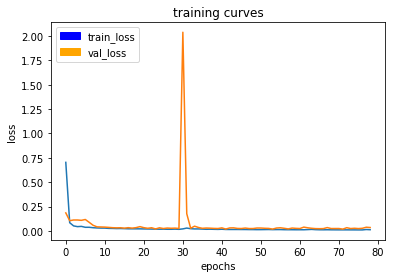

75/75 [==============================] - 136s - loss: 0.0131 - val_loss: 0.0354
Epoch 80/250
74/75 [============================>.] - ETA: 1s - loss: 0.0122

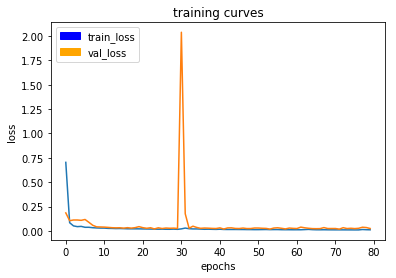

75/75 [==============================] - 138s - loss: 0.0122 - val_loss: 0.0255
Epoch 81/250
74/75 [============================>.] - ETA: 1s - loss: 0.0113

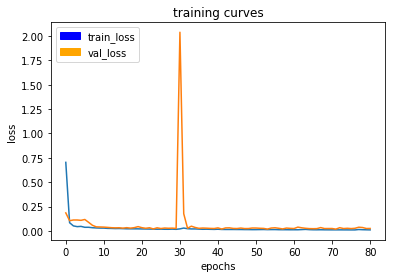

75/75 [==============================] - 137s - loss: 0.0113 - val_loss: 0.0259
Epoch 82/250
74/75 [============================>.] - ETA: 1s - loss: 0.0116

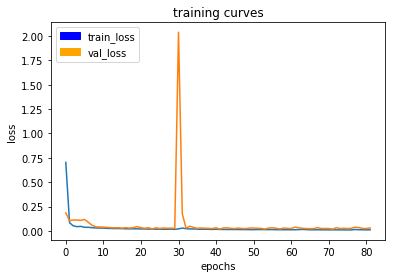

75/75 [==============================] - 137s - loss: 0.0116 - val_loss: 0.0311
Epoch 83/250
74/75 [============================>.] - ETA: 1s - loss: 0.0121

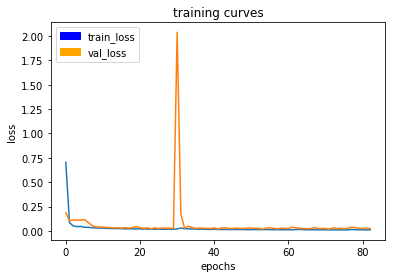

75/75 [==============================] - 137s - loss: 0.0121 - val_loss: 0.0259
Epoch 84/250
74/75 [============================>.] - ETA: 1s - loss: 0.0113

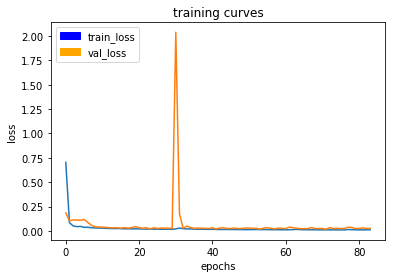

75/75 [==============================] - 137s - loss: 0.0113 - val_loss: 0.0258
Epoch 85/250
74/75 [============================>.] - ETA: 1s - loss: 0.0111

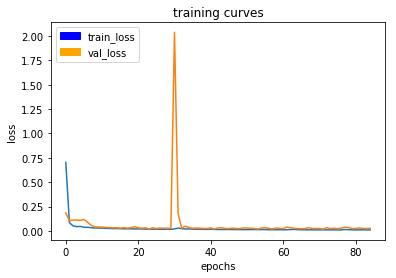

75/75 [==============================] - 137s - loss: 0.0111 - val_loss: 0.0275
Epoch 86/250
74/75 [============================>.] - ETA: 1s - loss: 0.0106

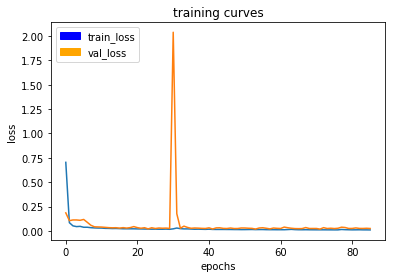

75/75 [==============================] - 137s - loss: 0.0106 - val_loss: 0.0252
Epoch 87/250
74/75 [============================>.] - ETA: 1s - loss: 0.0107

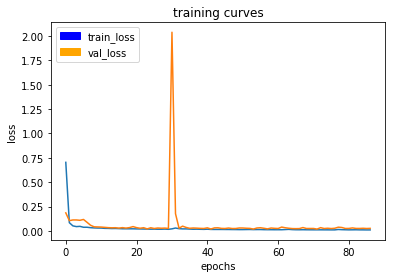

75/75 [==============================] - 137s - loss: 0.0107 - val_loss: 0.0265
Epoch 88/250
74/75 [============================>.] - ETA: 1s - loss: 0.0111

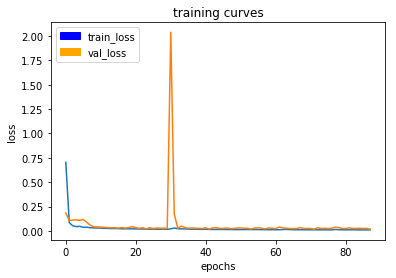

75/75 [==============================] - 136s - loss: 0.0111 - val_loss: 0.0188
Epoch 89/250
74/75 [============================>.] - ETA: 1s - loss: 0.0107

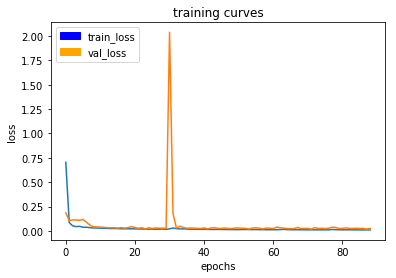

75/75 [==============================] - 138s - loss: 0.0107 - val_loss: 0.0265
Epoch 90/250
74/75 [============================>.] - ETA: 1s - loss: 0.0112

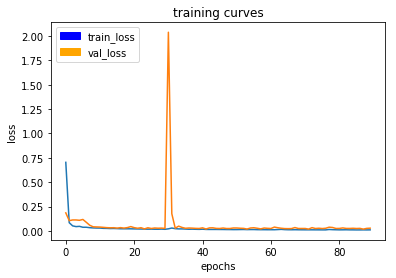

75/75 [==============================] - 137s - loss: 0.0112 - val_loss: 0.0284
Epoch 91/250
74/75 [============================>.] - ETA: 1s - loss: 0.0139

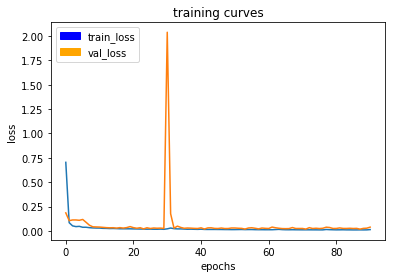

75/75 [==============================] - 137s - loss: 0.0139 - val_loss: 0.0391
Epoch 92/250
74/75 [============================>.] - ETA: 1s - loss: 0.0136

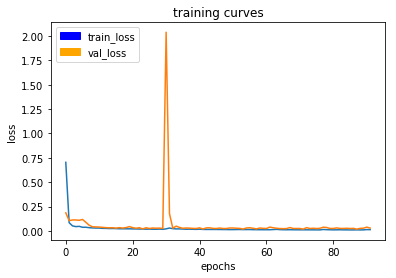

75/75 [==============================] - 136s - loss: 0.0136 - val_loss: 0.0294
Epoch 93/250
74/75 [============================>.] - ETA: 1s - loss: 0.0116

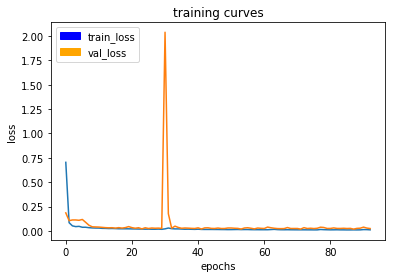

75/75 [==============================] - 137s - loss: 0.0116 - val_loss: 0.0246
Epoch 94/250
74/75 [============================>.] - ETA: 1s - loss: 0.0107

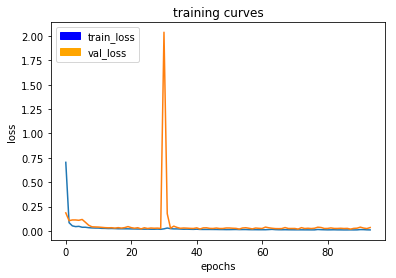

75/75 [==============================] - 138s - loss: 0.0107 - val_loss: 0.0350
Epoch 95/250
74/75 [============================>.] - ETA: 1s - loss: 0.0104

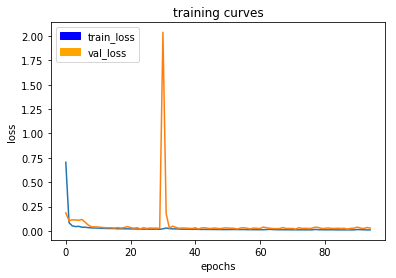

75/75 [==============================] - 137s - loss: 0.0104 - val_loss: 0.0301
Epoch 96/250
74/75 [============================>.] - ETA: 1s - loss: 0.0101

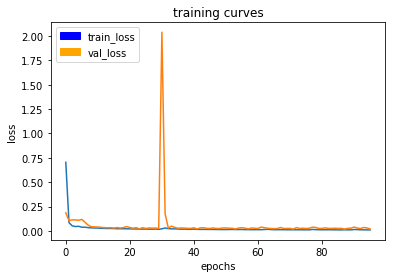

75/75 [==============================] - 137s - loss: 0.0102 - val_loss: 0.0204
Epoch 97/250
74/75 [============================>.] - ETA: 1s - loss: 0.0101

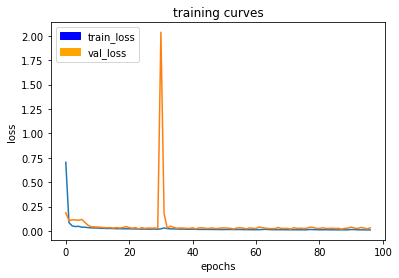

75/75 [==============================] - 137s - loss: 0.0100 - val_loss: 0.0320
Epoch 98/250
74/75 [============================>.] - ETA: 1s - loss: 0.0099

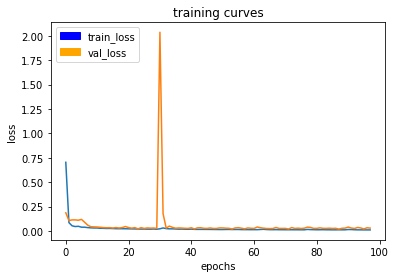

75/75 [==============================] - 137s - loss: 0.0099 - val_loss: 0.0286
Epoch 99/250
74/75 [============================>.] - ETA: 1s - loss: 0.0099

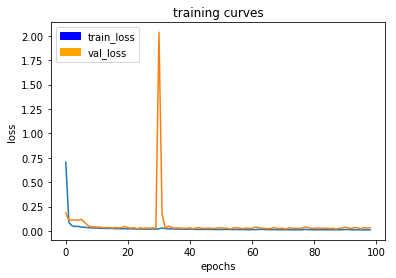

75/75 [==============================] - 138s - loss: 0.0099 - val_loss: 0.0318
Epoch 100/250
74/75 [============================>.] - ETA: 1s - loss: 0.0100

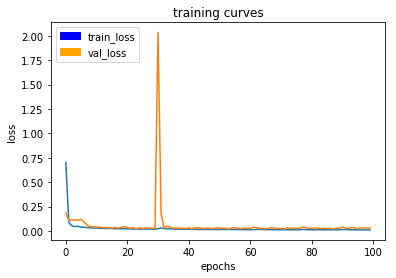

75/75 [==============================] - 136s - loss: 0.0100 - val_loss: 0.0303
Epoch 101/250
74/75 [============================>.] - ETA: 1s - loss: 0.0158

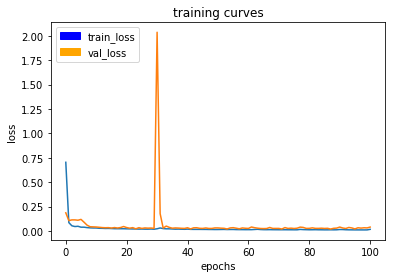

75/75 [==============================] - 137s - loss: 0.0158 - val_loss: 0.0389
Epoch 102/250
74/75 [============================>.] - ETA: 1s - loss: 0.0132

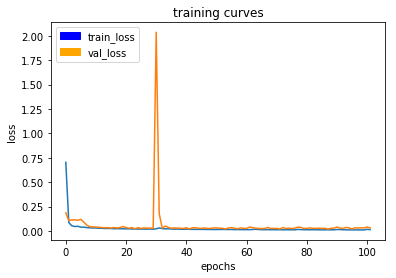

75/75 [==============================] - 137s - loss: 0.0132 - val_loss: 0.0317
Epoch 103/250
74/75 [============================>.] - ETA: 1s - loss: 0.0109

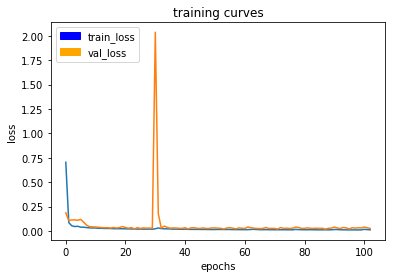

75/75 [==============================] - 138s - loss: 0.0109 - val_loss: 0.0250
Epoch 104/250
74/75 [============================>.] - ETA: 1s - loss: 0.0104

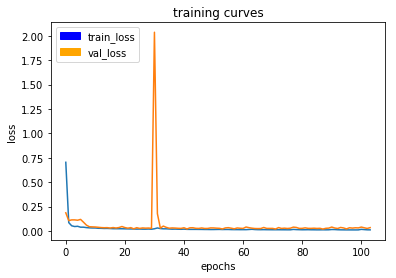

75/75 [==============================] - 137s - loss: 0.0104 - val_loss: 0.0333
Epoch 105/250
74/75 [============================>.] - ETA: 1s - loss: 0.0105

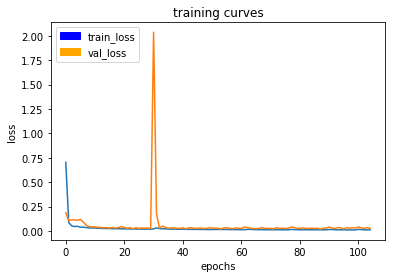

75/75 [==============================] - 137s - loss: 0.0105 - val_loss: 0.0260
Epoch 106/250
74/75 [============================>.] - ETA: 1s - loss: 0.0099

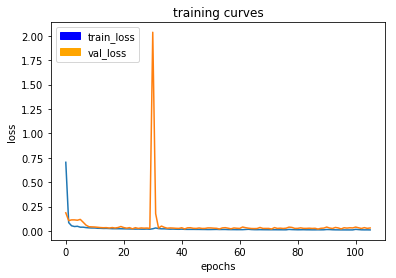

75/75 [==============================] - 136s - loss: 0.0099 - val_loss: 0.0299
Epoch 107/250
74/75 [============================>.] - ETA: 1s - loss: 0.0099

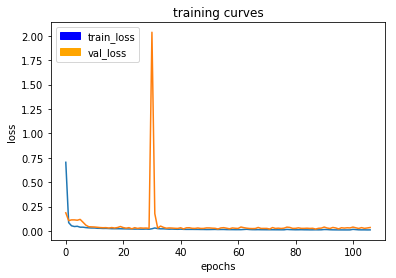

75/75 [==============================] - 136s - loss: 0.0102 - val_loss: 0.0345
Epoch 108/250
74/75 [============================>.] - ETA: 1s - loss: 0.0146

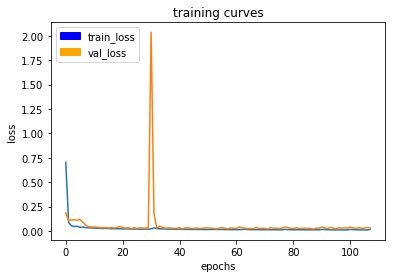

75/75 [==============================] - 137s - loss: 0.0146 - val_loss: 0.0317
Epoch 109/250
74/75 [============================>.] - ETA: 1s - loss: 0.0112

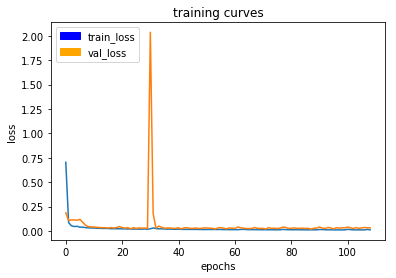

75/75 [==============================] - 137s - loss: 0.0112 - val_loss: 0.0321
Epoch 110/250
74/75 [============================>.] - ETA: 1s - loss: 0.0104

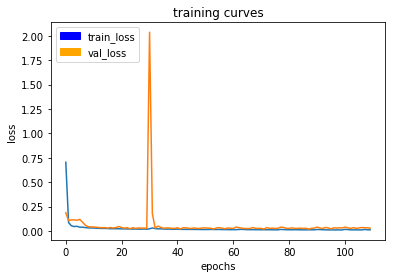

75/75 [==============================] - 136s - loss: 0.0104 - val_loss: 0.0264
Epoch 111/250
74/75 [============================>.] - ETA: 1s - loss: 0.0103

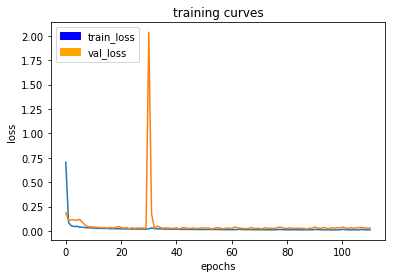

75/75 [==============================] - 136s - loss: 0.0103 - val_loss: 0.0314
Epoch 112/250
74/75 [============================>.] - ETA: 1s - loss: 0.0101

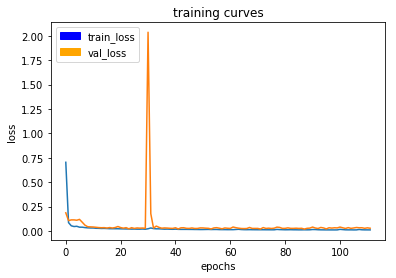

75/75 [==============================] - 137s - loss: 0.0101 - val_loss: 0.0270
Epoch 113/250
74/75 [============================>.] - ETA: 1s - loss: 0.0096

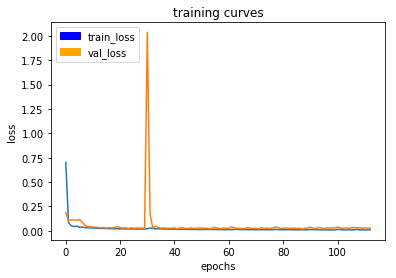

75/75 [==============================] - 139s - loss: 0.0096 - val_loss: 0.0264
Epoch 114/250
74/75 [============================>.] - ETA: 1s - loss: 0.0098

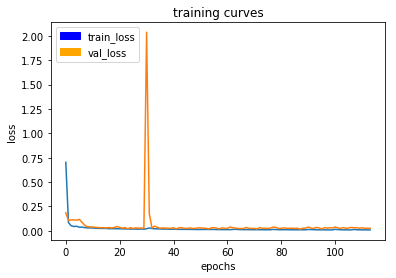

75/75 [==============================] - 137s - loss: 0.0098 - val_loss: 0.0269
Epoch 115/250
74/75 [============================>.] - ETA: 1s - loss: 0.0095

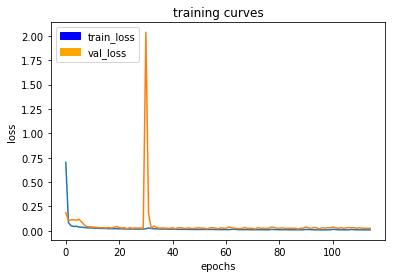

75/75 [==============================] - 137s - loss: 0.0095 - val_loss: 0.0261
Epoch 116/250
74/75 [============================>.] - ETA: 1s - loss: 0.0095

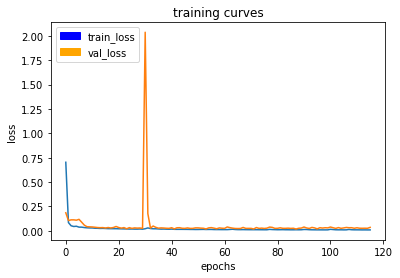

75/75 [==============================] - 137s - loss: 0.0095 - val_loss: 0.0355
Epoch 117/250
74/75 [============================>.] - ETA: 1s - loss: 0.0093

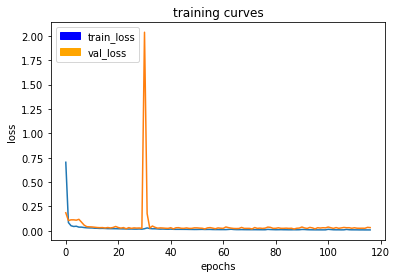

75/75 [==============================] - 138s - loss: 0.0094 - val_loss: 0.0331
Epoch 118/250
74/75 [============================>.] - ETA: 1s - loss: 0.0094

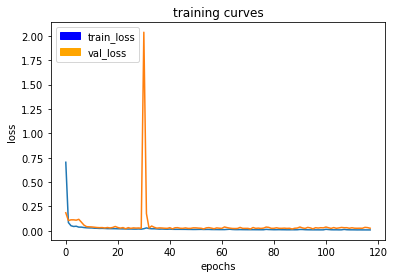

75/75 [==============================] - 137s - loss: 0.0094 - val_loss: 0.0265
Epoch 119/250
74/75 [============================>.] - ETA: 1s - loss: 0.0094

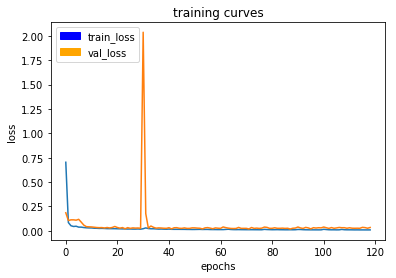

75/75 [==============================] - 137s - loss: 0.0094 - val_loss: 0.0343
Epoch 120/250
74/75 [============================>.] - ETA: 1s - loss: 0.0092

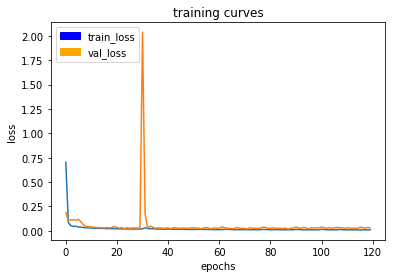

75/75 [==============================] - 136s - loss: 0.0092 - val_loss: 0.0296
Epoch 121/250
74/75 [============================>.] - ETA: 1s - loss: 0.0093

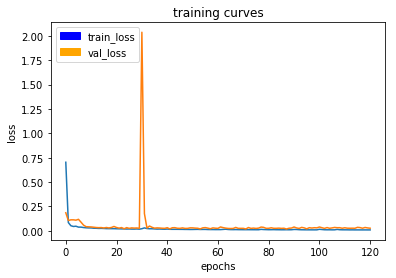

75/75 [==============================] - 137s - loss: 0.0093 - val_loss: 0.0265
Epoch 122/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

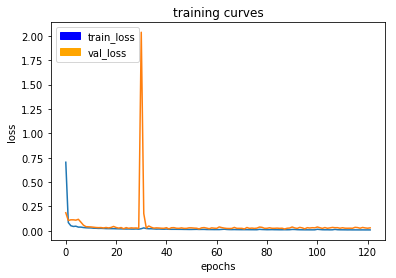

75/75 [==============================] - 138s - loss: 0.0091 - val_loss: 0.0303
Epoch 123/250
74/75 [============================>.] - ETA: 1s - loss: 0.0092

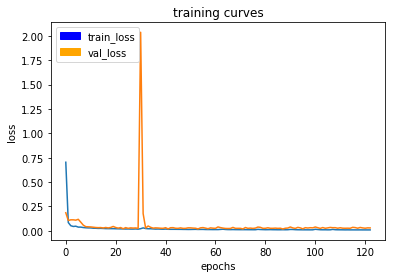

75/75 [==============================] - 137s - loss: 0.0092 - val_loss: 0.0294
Epoch 124/250
74/75 [============================>.] - ETA: 1s - loss: 0.0092

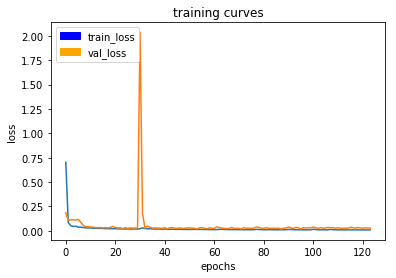

75/75 [==============================] - 137s - loss: 0.0092 - val_loss: 0.0283
Epoch 125/250
74/75 [============================>.] - ETA: 1s - loss: 0.0093

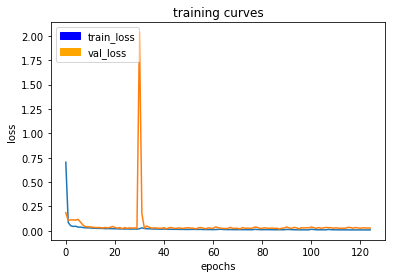

75/75 [==============================] - 137s - loss: 0.0093 - val_loss: 0.0274
Epoch 126/250
74/75 [============================>.] - ETA: 1s - loss: 0.0143

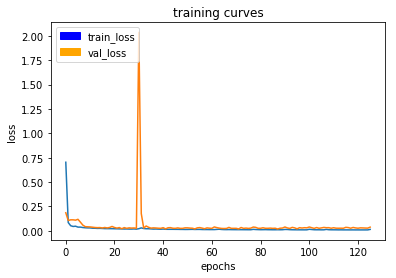

75/75 [==============================] - 137s - loss: 0.0143 - val_loss: 0.0376
Epoch 127/250
74/75 [============================>.] - ETA: 1s - loss: 0.0132

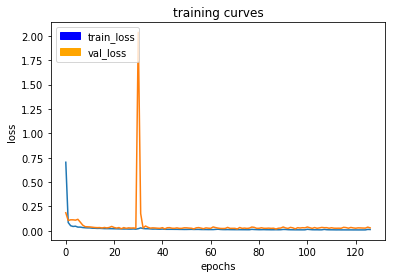

75/75 [==============================] - 138s - loss: 0.0132 - val_loss: 0.0299
Epoch 128/250
74/75 [============================>.] - ETA: 1s - loss: 0.0106

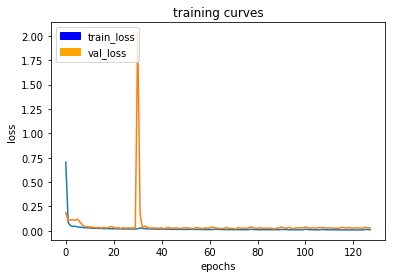

75/75 [==============================] - 137s - loss: 0.0106 - val_loss: 0.0313
Epoch 129/250
74/75 [============================>.] - ETA: 1s - loss: 0.0106

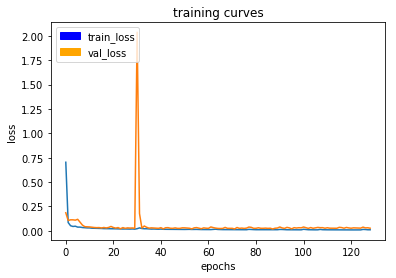

75/75 [==============================] - 136s - loss: 0.0106 - val_loss: 0.0265
Epoch 130/250
74/75 [============================>.] - ETA: 1s - loss: 0.0095

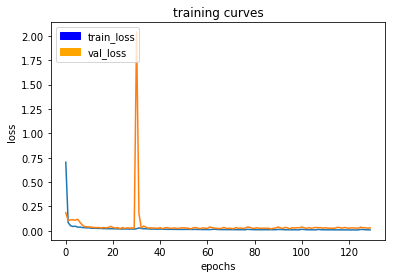

75/75 [==============================] - 136s - loss: 0.0095 - val_loss: 0.0299
Epoch 131/250
74/75 [============================>.] - ETA: 1s - loss: 0.0092

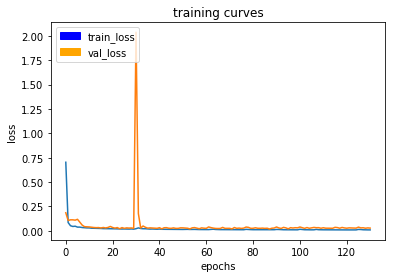

75/75 [==============================] - 138s - loss: 0.0092 - val_loss: 0.0276
Epoch 132/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

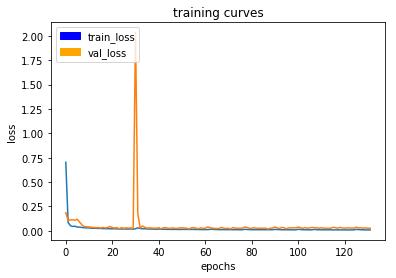

75/75 [==============================] - 136s - loss: 0.0091 - val_loss: 0.0271
Epoch 133/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

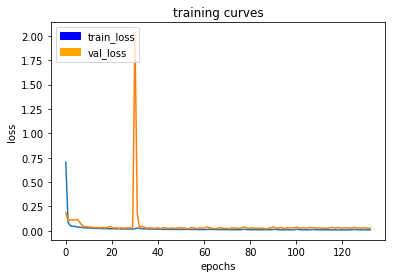

75/75 [==============================] - 137s - loss: 0.0091 - val_loss: 0.0265
Epoch 134/250
74/75 [============================>.] - ETA: 1s - loss: 0.0090

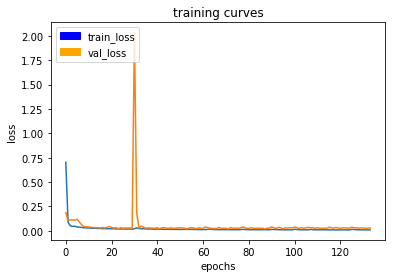

75/75 [==============================] - 136s - loss: 0.0090 - val_loss: 0.0298
Epoch 135/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

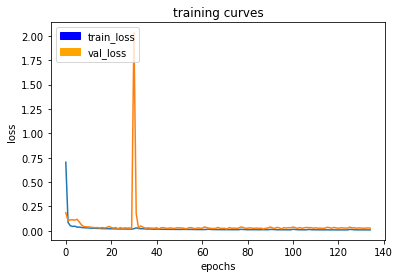

75/75 [==============================] - 136s - loss: 0.0091 - val_loss: 0.0274
Epoch 136/250
74/75 [============================>.] - ETA: 1s - loss: 0.0089

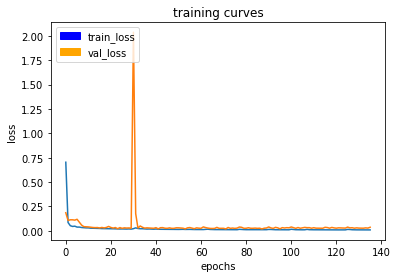

75/75 [==============================] - 137s - loss: 0.0089 - val_loss: 0.0362
Epoch 137/250
74/75 [============================>.] - ETA: 1s - loss: 0.0089

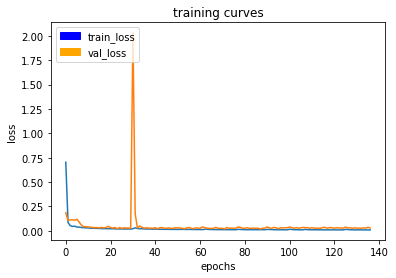

75/75 [==============================] - 137s - loss: 0.0089 - val_loss: 0.0283
Epoch 138/250
74/75 [============================>.] - ETA: 1s - loss: 0.0088

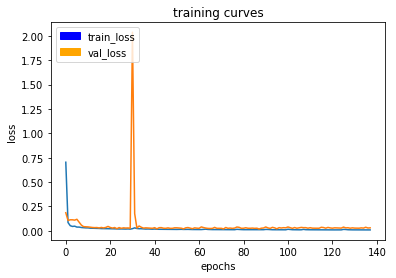

75/75 [==============================] - 137s - loss: 0.0088 - val_loss: 0.0302
Epoch 139/250
74/75 [============================>.] - ETA: 1s - loss: 0.0089

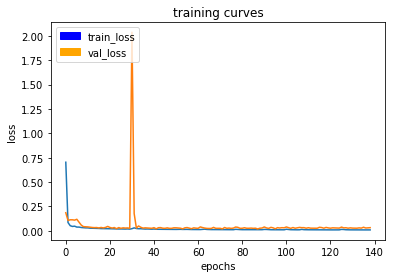

75/75 [==============================] - 137s - loss: 0.0089 - val_loss: 0.0319
Epoch 140/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

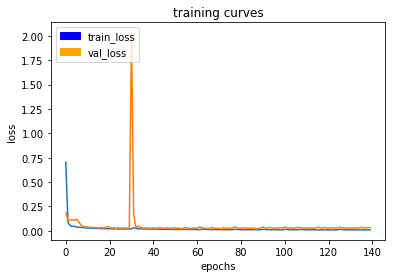

75/75 [==============================] - 138s - loss: 0.0091 - val_loss: 0.0329
Epoch 141/250
74/75 [============================>.] - ETA: 1s - loss: 0.0100

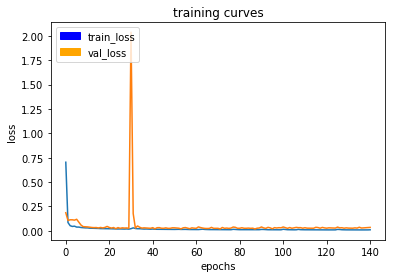

75/75 [==============================] - 138s - loss: 0.0100 - val_loss: 0.0346
Epoch 142/250
74/75 [============================>.] - ETA: 1s - loss: 0.0125

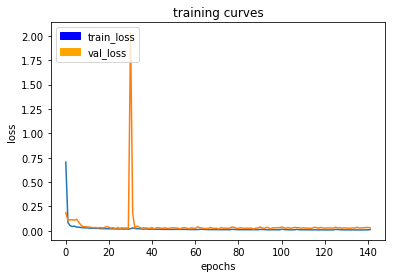

75/75 [==============================] - 137s - loss: 0.0125 - val_loss: 0.0300
Epoch 143/250
74/75 [============================>.] - ETA: 1s - loss: 0.0099

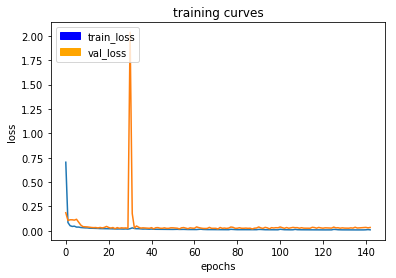

75/75 [==============================] - 137s - loss: 0.0099 - val_loss: 0.0339
Epoch 144/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

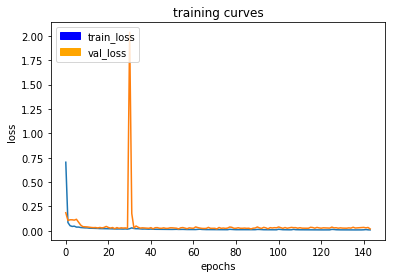

75/75 [==============================] - 137s - loss: 0.0091 - val_loss: 0.0193
Epoch 145/250
74/75 [============================>.] - ETA: 1s - loss: 0.0090

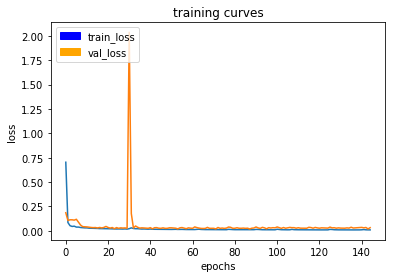

75/75 [==============================] - 138s - loss: 0.0091 - val_loss: 0.0317
Epoch 146/250
74/75 [============================>.] - ETA: 1s - loss: 0.0115

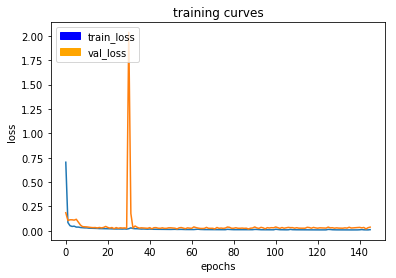

75/75 [==============================] - 136s - loss: 0.0115 - val_loss: 0.0373
Epoch 147/250
74/75 [============================>.] - ETA: 1s - loss: 0.0103

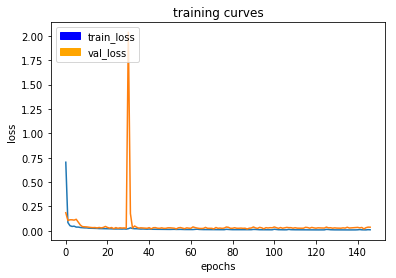

75/75 [==============================] - 137s - loss: 0.0103 - val_loss: 0.0366
Epoch 148/250
74/75 [============================>.] - ETA: 1s - loss: 0.0092

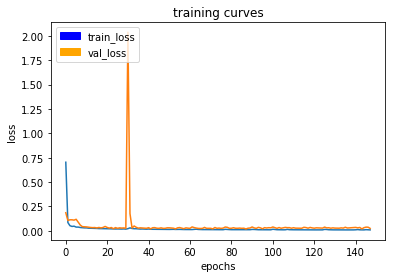

75/75 [==============================] - 137s - loss: 0.0092 - val_loss: 0.0244
Epoch 149/250
74/75 [============================>.] - ETA: 1s - loss: 0.0088

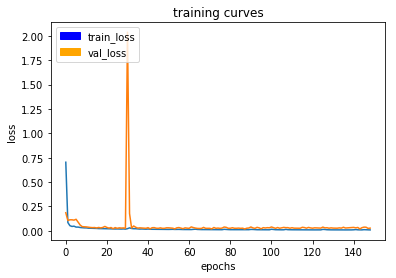

75/75 [==============================] - 137s - loss: 0.0088 - val_loss: 0.0270
Epoch 150/250
74/75 [============================>.] - ETA: 1s - loss: 0.0087

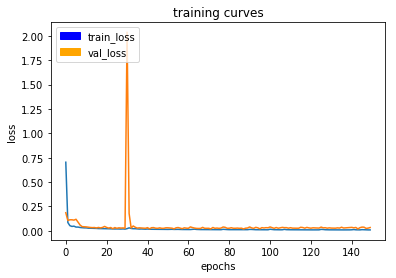

75/75 [==============================] - 139s - loss: 0.0087 - val_loss: 0.0332
Epoch 151/250
74/75 [============================>.] - ETA: 1s - loss: 0.0087

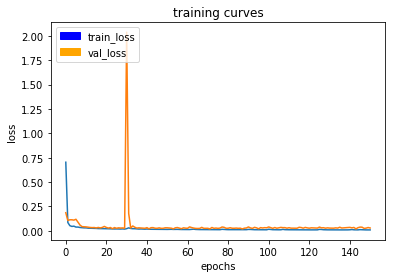

75/75 [==============================] - 137s - loss: 0.0087 - val_loss: 0.0282
Epoch 152/250
74/75 [============================>.] - ETA: 1s - loss: 0.0086

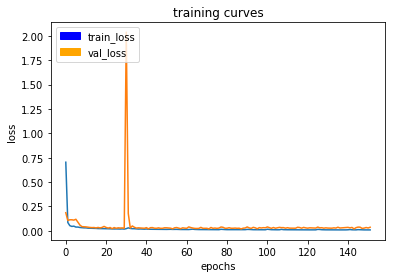

75/75 [==============================] - 137s - loss: 0.0086 - val_loss: 0.0360
Epoch 153/250
74/75 [============================>.] - ETA: 1s - loss: 0.0087

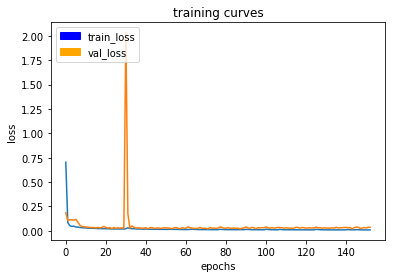

75/75 [==============================] - 137s - loss: 0.0087 - val_loss: 0.0353
Epoch 154/250
74/75 [============================>.] - ETA: 1s - loss: 0.0086

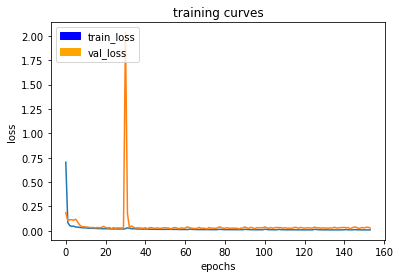

75/75 [==============================] - 137s - loss: 0.0086 - val_loss: 0.0282
Epoch 155/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

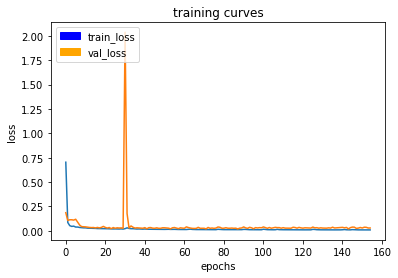

75/75 [==============================] - 138s - loss: 0.0084 - val_loss: 0.0281
Epoch 156/250
74/75 [============================>.] - ETA: 1s - loss: 0.0085

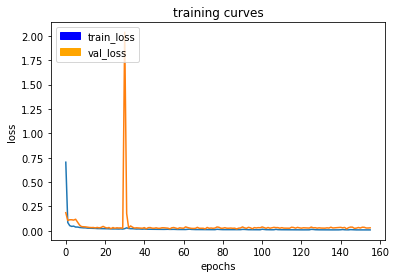

75/75 [==============================] - 136s - loss: 0.0085 - val_loss: 0.0299
Epoch 157/250
74/75 [============================>.] - ETA: 1s - loss: 0.0085

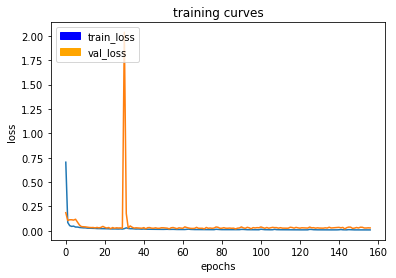

75/75 [==============================] - 137s - loss: 0.0085 - val_loss: 0.0287
Epoch 158/250
74/75 [============================>.] - ETA: 1s - loss: 0.0085

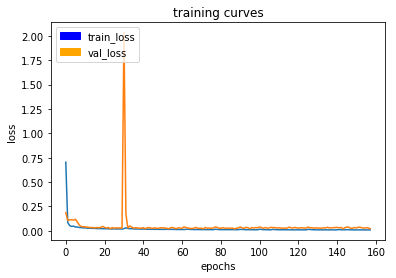

75/75 [==============================] - 137s - loss: 0.0085 - val_loss: 0.0215
Epoch 159/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

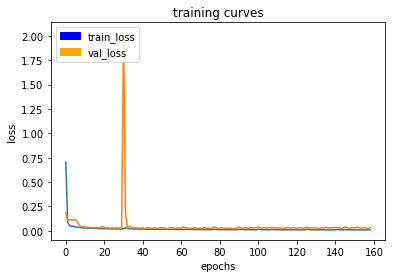

75/75 [==============================] - 138s - loss: 0.0085 - val_loss: 0.0305
Epoch 160/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

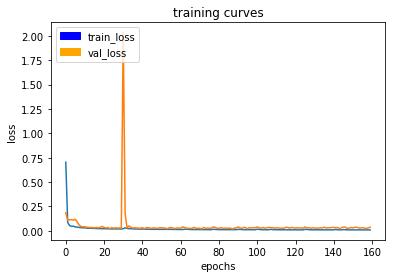

75/75 [==============================] - 136s - loss: 0.0084 - val_loss: 0.0350
Epoch 161/250
74/75 [============================>.] - ETA: 1s - loss: 0.0085

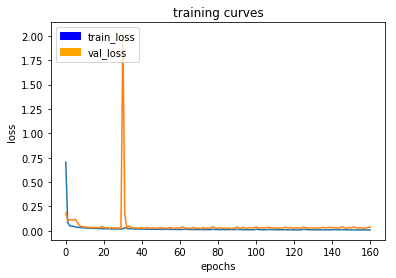

75/75 [==============================] - 138s - loss: 0.0085 - val_loss: 0.0358
Epoch 162/250
74/75 [============================>.] - ETA: 1s - loss: 0.0085

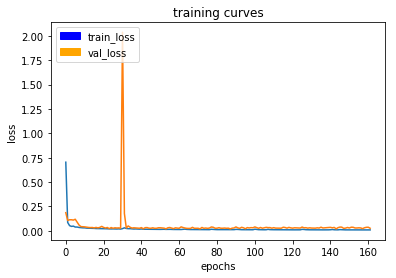

75/75 [==============================] - 137s - loss: 0.0085 - val_loss: 0.0252
Epoch 163/250
74/75 [============================>.] - ETA: 1s - loss: 0.0123

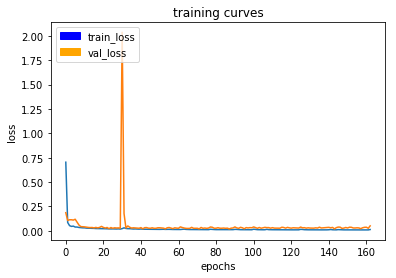

75/75 [==============================] - 137s - loss: 0.0124 - val_loss: 0.0498
Epoch 164/250
74/75 [============================>.] - ETA: 1s - loss: 0.0158

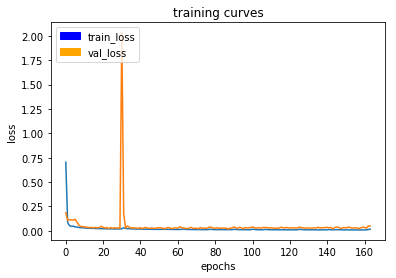

75/75 [==============================] - 138s - loss: 0.0158 - val_loss: 0.0477
Epoch 165/250
74/75 [============================>.] - ETA: 1s - loss: 0.0108

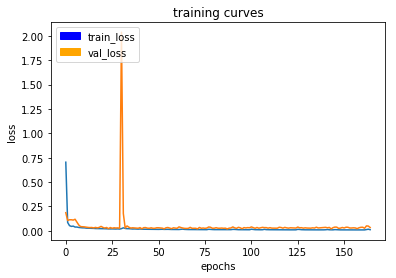

75/75 [==============================] - 137s - loss: 0.0108 - val_loss: 0.0330
Epoch 166/250
74/75 [============================>.] - ETA: 1s - loss: 0.0093

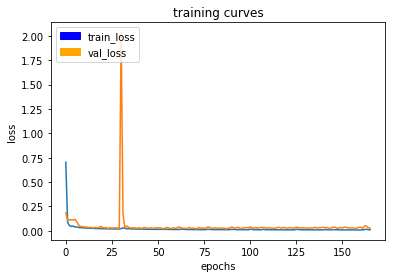

75/75 [==============================] - 137s - loss: 0.0093 - val_loss: 0.0238
Epoch 167/250
74/75 [============================>.] - ETA: 1s - loss: 0.0088

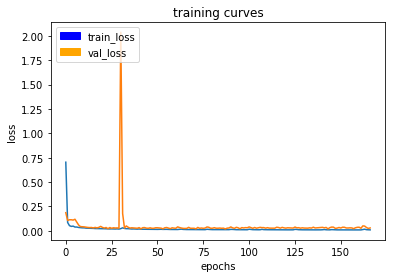

75/75 [==============================] - 137s - loss: 0.0088 - val_loss: 0.0287
Epoch 168/250
74/75 [============================>.] - ETA: 1s - loss: 0.0087

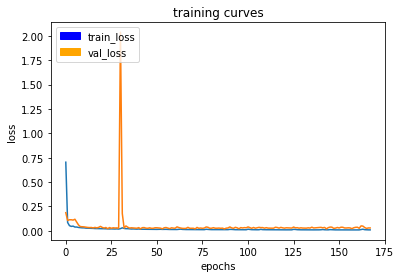

75/75 [==============================] - 137s - loss: 0.0087 - val_loss: 0.0284
Epoch 169/250
74/75 [============================>.] - ETA: 1s - loss: 0.0086

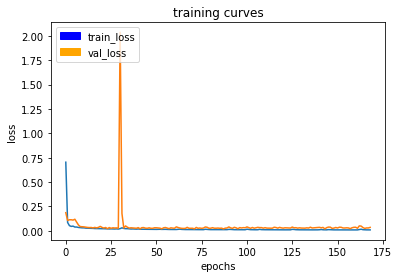

75/75 [==============================] - 139s - loss: 0.0085 - val_loss: 0.0345
Epoch 170/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

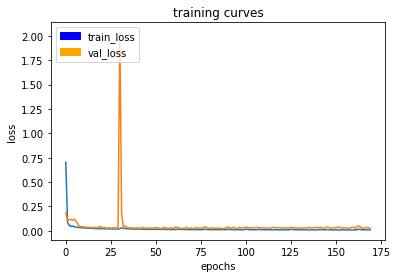

75/75 [==============================] - 136s - loss: 0.0084 - val_loss: 0.0210
Epoch 171/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

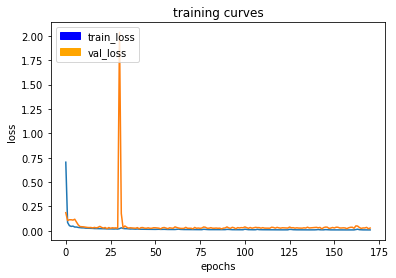

75/75 [==============================] - 136s - loss: 0.0084 - val_loss: 0.0277
Epoch 172/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

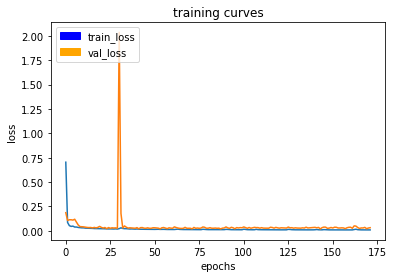

75/75 [==============================] - 137s - loss: 0.0084 - val_loss: 0.0310
Epoch 173/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

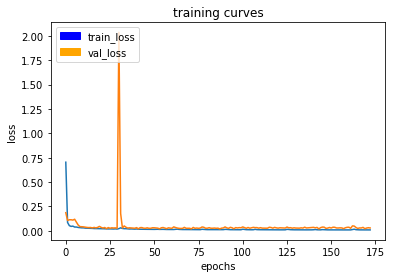

75/75 [==============================] - 138s - loss: 0.0084 - val_loss: 0.0283
Epoch 174/250
74/75 [============================>.] - ETA: 1s - loss: 0.0083

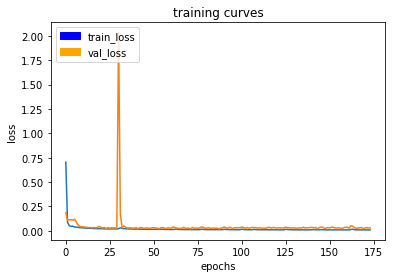

75/75 [==============================] - 137s - loss: 0.0083 - val_loss: 0.0300
Epoch 175/250
74/75 [============================>.] - ETA: 1s - loss: 0.0083

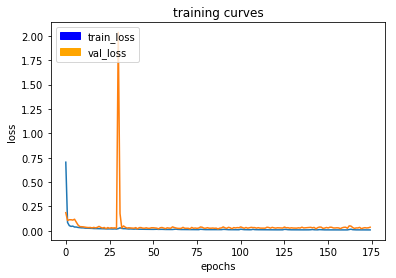

75/75 [==============================] - 137s - loss: 0.0083 - val_loss: 0.0360
Epoch 176/250
74/75 [============================>.] - ETA: 1s - loss: 0.0083

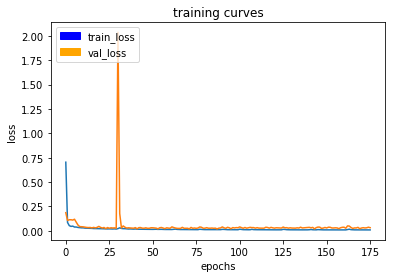

75/75 [==============================] - 137s - loss: 0.0083 - val_loss: 0.0311
Epoch 177/250
74/75 [============================>.] - ETA: 1s - loss: 0.0082

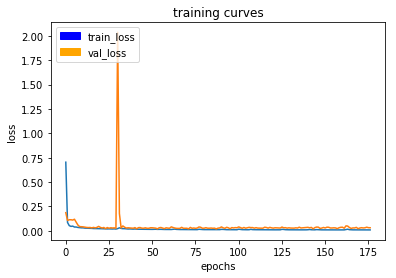

75/75 [==============================] - 137s - loss: 0.0082 - val_loss: 0.0304
Epoch 178/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

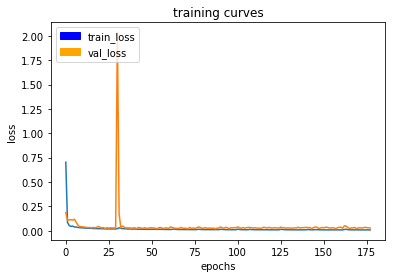

75/75 [==============================] - 138s - loss: 0.0081 - val_loss: 0.0286
Epoch 179/250
74/75 [============================>.] - ETA: 1s - loss: 0.0082

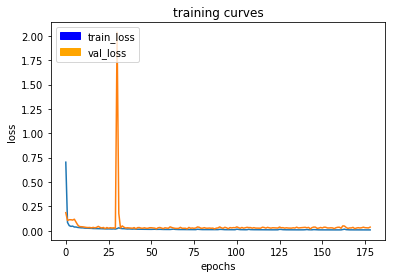

75/75 [==============================] - 136s - loss: 0.0082 - val_loss: 0.0370
Epoch 180/250
74/75 [============================>.] - ETA: 1s - loss: 0.0082

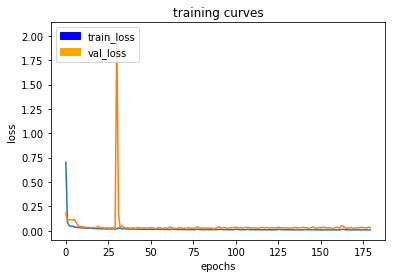

75/75 [==============================] - 137s - loss: 0.0082 - val_loss: 0.0322
Epoch 181/250
74/75 [============================>.] - ETA: 1s - loss: 0.0082

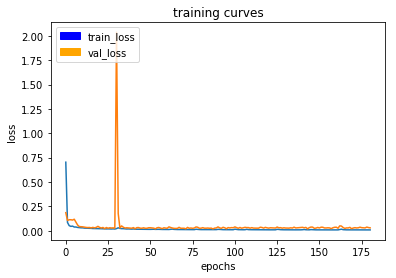

75/75 [==============================] - 137s - loss: 0.0082 - val_loss: 0.0290
Epoch 182/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

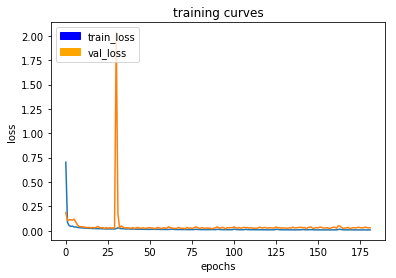

75/75 [==============================] - 137s - loss: 0.0081 - val_loss: 0.0305
Epoch 183/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

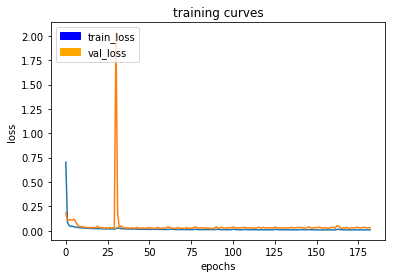

75/75 [==============================] - 138s - loss: 0.0081 - val_loss: 0.0299
Epoch 184/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

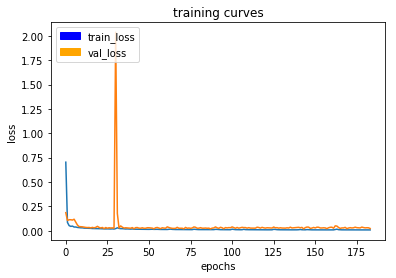

75/75 [==============================] - 137s - loss: 0.0081 - val_loss: 0.0228
Epoch 185/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

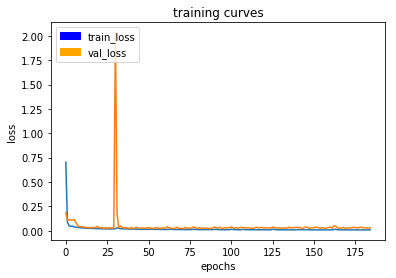

75/75 [==============================] - 136s - loss: 0.0081 - val_loss: 0.0302
Epoch 186/250
74/75 [============================>.] - ETA: 1s - loss: 0.0087

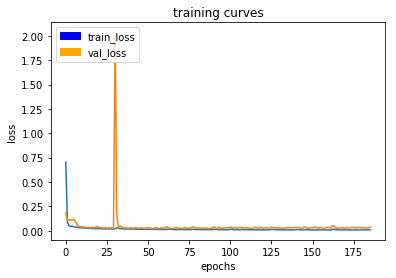

75/75 [==============================] - 136s - loss: 0.0087 - val_loss: 0.0380
Epoch 187/250
74/75 [============================>.] - ETA: 1s - loss: 0.0105

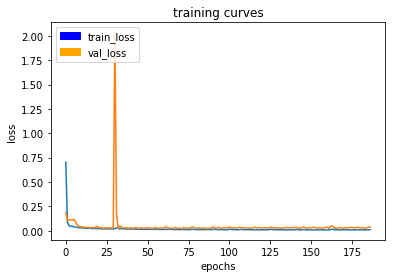

75/75 [==============================] - 138s - loss: 0.0106 - val_loss: 0.0350
Epoch 188/250
74/75 [============================>.] - ETA: 1s - loss: 0.0142

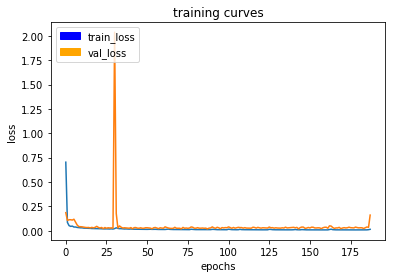

75/75 [==============================] - 137s - loss: 0.0142 - val_loss: 0.1603
Epoch 189/250
74/75 [============================>.] - ETA: 1s - loss: 0.0113

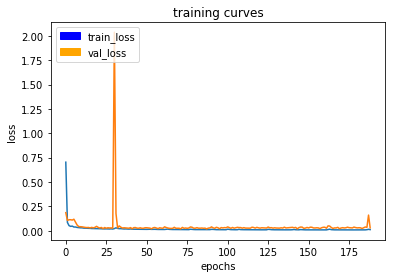

75/75 [==============================] - 137s - loss: 0.0113 - val_loss: 0.0290
Epoch 190/250
74/75 [============================>.] - ETA: 1s - loss: 0.0096

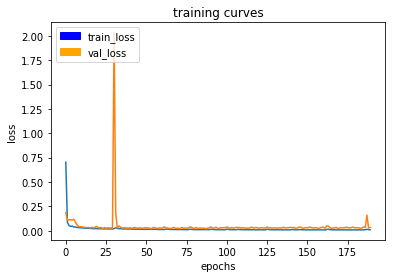

75/75 [==============================] - 136s - loss: 0.0096 - val_loss: 0.0342
Epoch 191/250
74/75 [============================>.] - ETA: 1s - loss: 0.0090

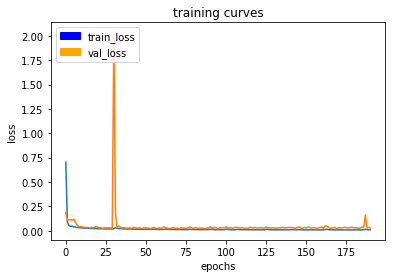

75/75 [==============================] - 137s - loss: 0.0090 - val_loss: 0.0271
Epoch 192/250
74/75 [============================>.] - ETA: 1s - loss: 0.0085

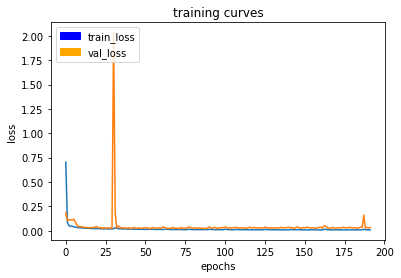

75/75 [==============================] - 137s - loss: 0.0085 - val_loss: 0.0349
Epoch 193/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

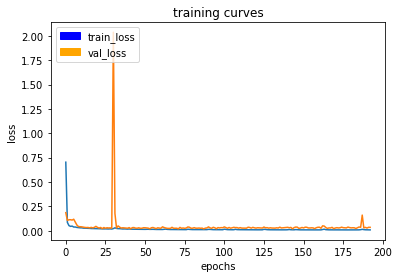

75/75 [==============================] - 137s - loss: 0.0084 - val_loss: 0.0346
Epoch 194/250
74/75 [============================>.] - ETA: 1s - loss: 0.0083

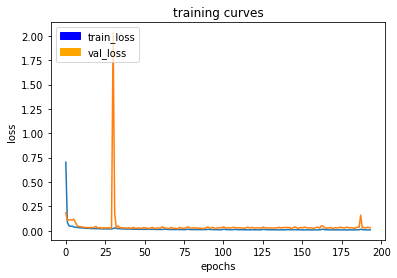

75/75 [==============================] - 137s - loss: 0.0083 - val_loss: 0.0295
Epoch 195/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

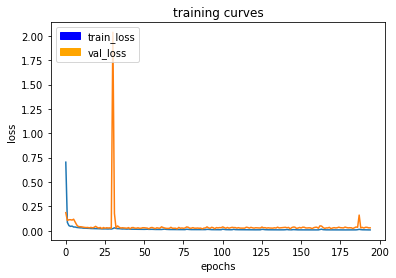

75/75 [==============================] - 137s - loss: 0.0081 - val_loss: 0.0294
Epoch 196/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

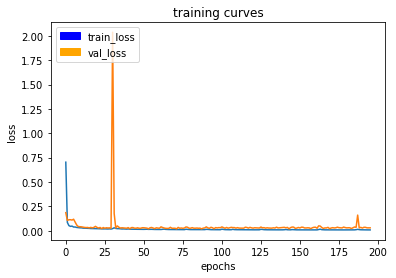

75/75 [==============================] - 137s - loss: 0.0082 - val_loss: 0.0294
Epoch 197/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

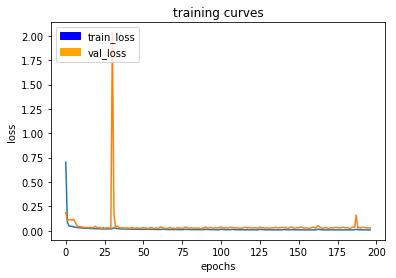

75/75 [==============================] - 138s - loss: 0.0081 - val_loss: 0.0287
Epoch 198/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

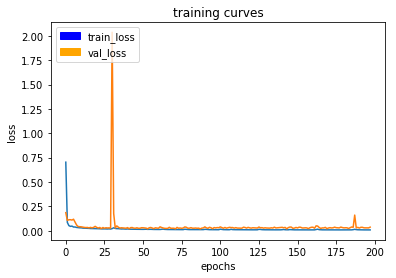

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0365
Epoch 199/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

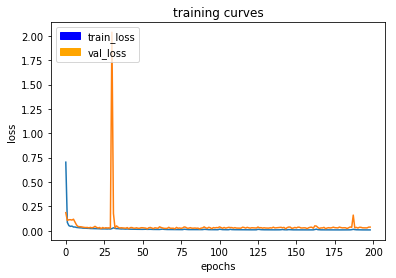

75/75 [==============================] - 136s - loss: 0.0080 - val_loss: 0.0370
Epoch 200/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

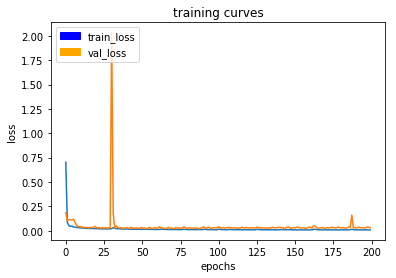

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0295
Epoch 201/250
74/75 [============================>.] - ETA: 1s - loss: 0.0082

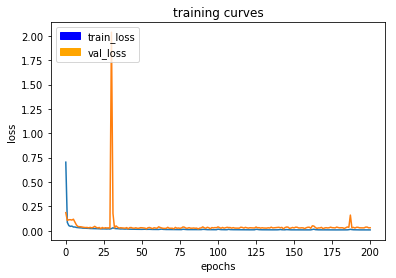

75/75 [==============================] - 139s - loss: 0.0082 - val_loss: 0.0302
Epoch 202/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

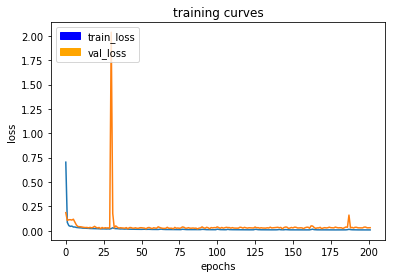

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0306
Epoch 203/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

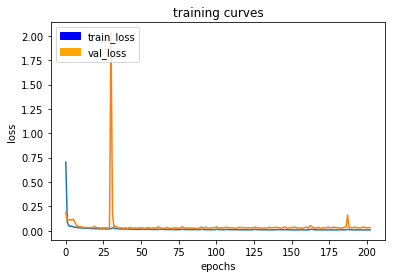

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0316
Epoch 204/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

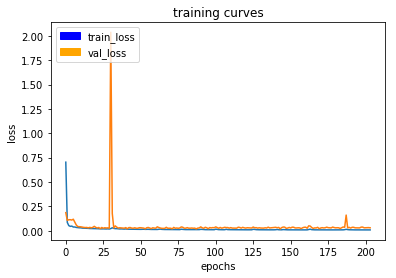

75/75 [==============================] - 136s - loss: 0.0080 - val_loss: 0.0296
Epoch 205/250
74/75 [============================>.] - ETA: 1s - loss: 0.0079

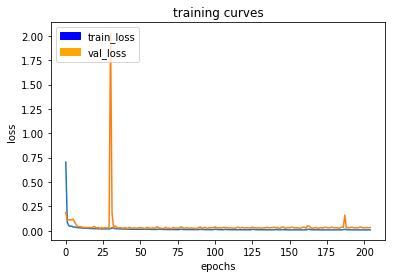

75/75 [==============================] - 138s - loss: 0.0079 - val_loss: 0.0324
Epoch 206/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

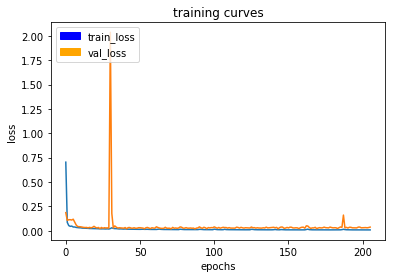

75/75 [==============================] - 138s - loss: 0.0078 - val_loss: 0.0367
Epoch 207/250
74/75 [============================>.] - ETA: 1s - loss: 0.0079

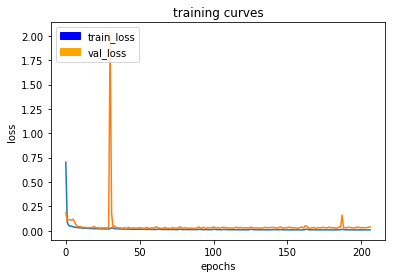

75/75 [==============================] - 137s - loss: 0.0079 - val_loss: 0.0387
Epoch 208/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

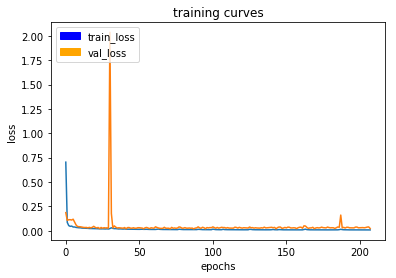

75/75 [==============================] - 137s - loss: 0.0078 - val_loss: 0.0226
Epoch 209/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

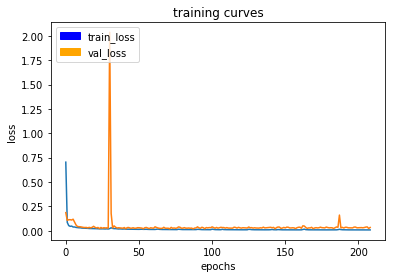

75/75 [==============================] - 136s - loss: 0.0078 - val_loss: 0.0328
Epoch 210/250
74/75 [============================>.] - ETA: 1s - loss: 0.0079

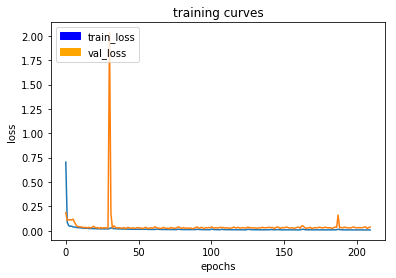

75/75 [==============================] - 138s - loss: 0.0079 - val_loss: 0.0373
Epoch 211/250
74/75 [============================>.] - ETA: 1s - loss: 0.0079

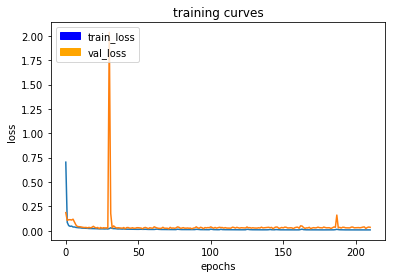

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0346
Epoch 212/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

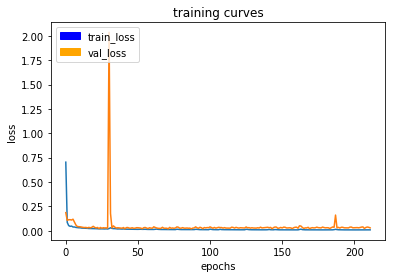

75/75 [==============================] - 137s - loss: 0.0084 - val_loss: 0.0286
Epoch 213/250
74/75 [============================>.] - ETA: 1s - loss: 0.0100

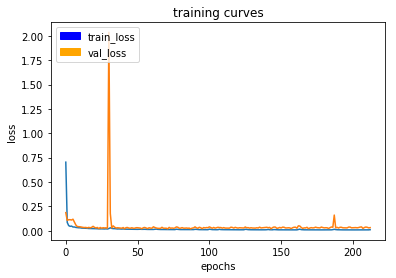

75/75 [==============================] - 137s - loss: 0.0101 - val_loss: 0.0312
Epoch 214/250
74/75 [============================>.] - ETA: 1s - loss: 0.0152

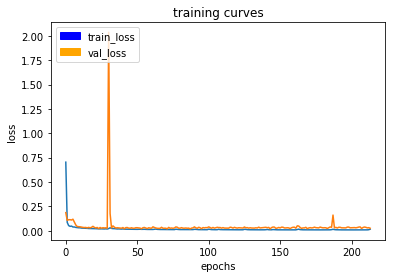

75/75 [==============================] - 137s - loss: 0.0151 - val_loss: 0.0250
Epoch 215/250
74/75 [============================>.] - ETA: 1s - loss: 0.0106

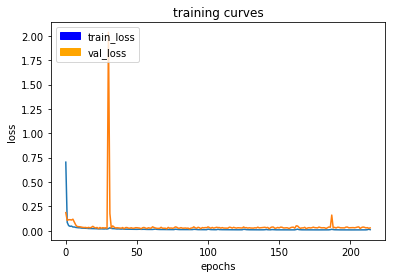

75/75 [==============================] - 138s - loss: 0.0106 - val_loss: 0.0285
Epoch 216/250
74/75 [============================>.] - ETA: 1s - loss: 0.0139

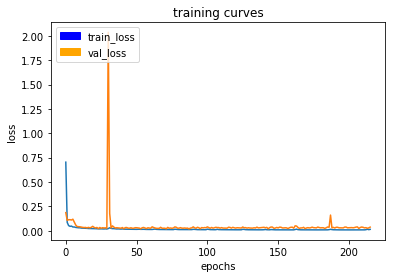

75/75 [==============================] - 136s - loss: 0.0138 - val_loss: 0.0366
Epoch 217/250
74/75 [============================>.] - ETA: 1s - loss: 0.0106

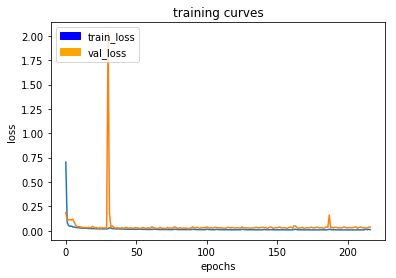

75/75 [==============================] - 136s - loss: 0.0106 - val_loss: 0.0370
Epoch 218/250
74/75 [============================>.] - ETA: 1s - loss: 0.0092

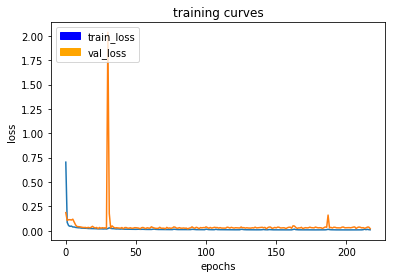

75/75 [==============================] - 136s - loss: 0.0092 - val_loss: 0.0216
Epoch 219/250
74/75 [============================>.] - ETA: 1s - loss: 0.0086

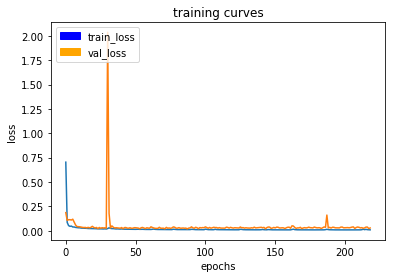

75/75 [==============================] - 137s - loss: 0.0086 - val_loss: 0.0278
Epoch 220/250
74/75 [============================>.] - ETA: 1s - loss: 0.0084

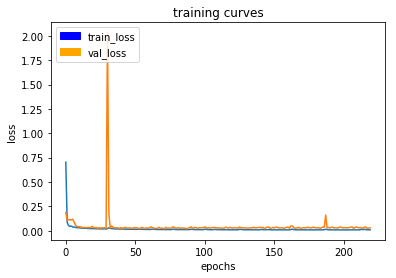

75/75 [==============================] - 138s - loss: 0.0084 - val_loss: 0.0295
Epoch 221/250
74/75 [============================>.] - ETA: 1s - loss: 0.0083

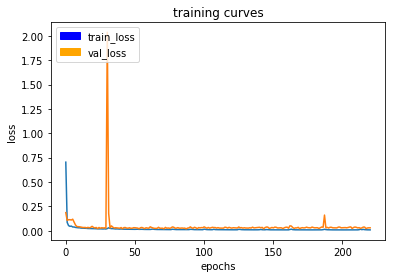

75/75 [==============================] - 137s - loss: 0.0082 - val_loss: 0.0293
Epoch 222/250
74/75 [============================>.] - ETA: 1s - loss: 0.0081

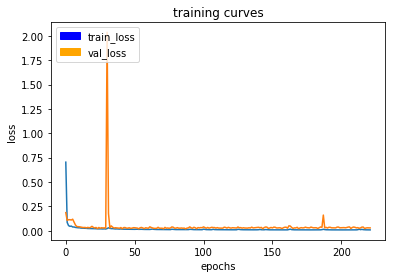

75/75 [==============================] - 137s - loss: 0.0081 - val_loss: 0.0284
Epoch 223/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

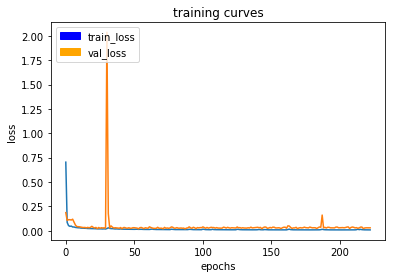

75/75 [==============================] - 136s - loss: 0.0080 - val_loss: 0.0292
Epoch 224/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

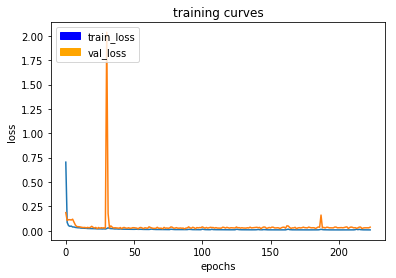

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0362
Epoch 225/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

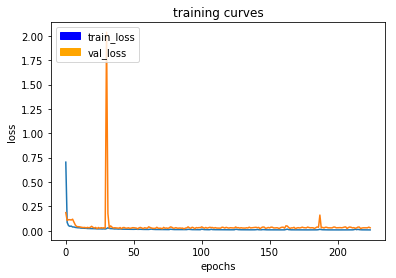

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0294
Epoch 226/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

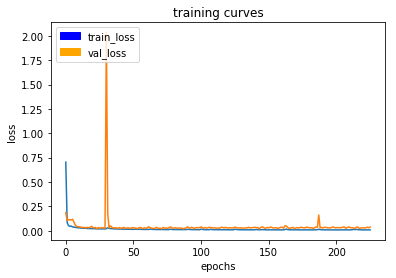

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0380
Epoch 227/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

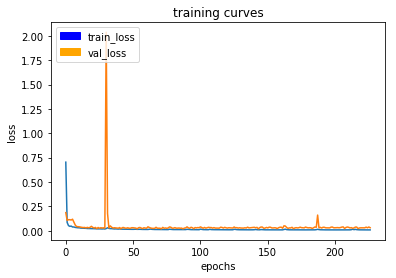

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0303
Epoch 228/250
74/75 [============================>.] - ETA: 1s - loss: 0.0079

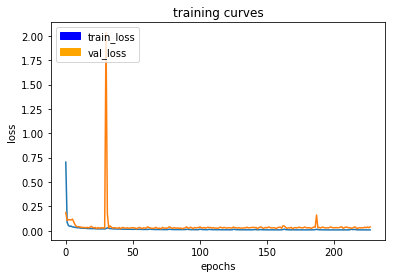

75/75 [==============================] - 136s - loss: 0.0079 - val_loss: 0.0387
Epoch 229/250
74/75 [============================>.] - ETA: 1s - loss: 0.0080

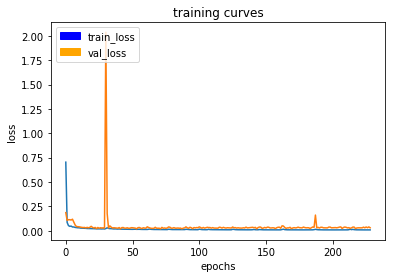

75/75 [==============================] - 137s - loss: 0.0080 - val_loss: 0.0298
Epoch 230/250
74/75 [============================>.] - ETA: 1s - loss: 0.0079

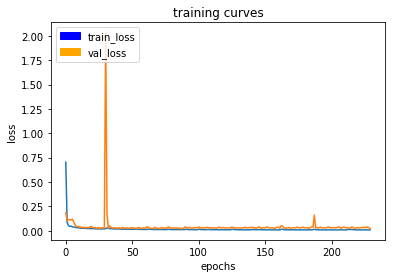

75/75 [==============================] - 136s - loss: 0.0079 - val_loss: 0.0220
Epoch 231/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

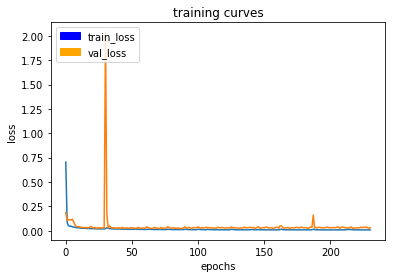

75/75 [==============================] - 138s - loss: 0.0078 - val_loss: 0.0311
Epoch 232/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

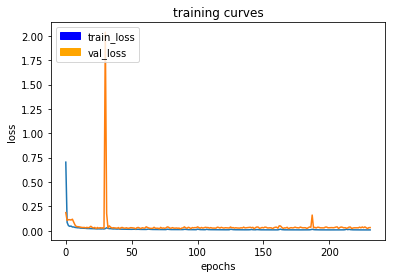

75/75 [==============================] - 137s - loss: 0.0078 - val_loss: 0.0318
Epoch 233/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

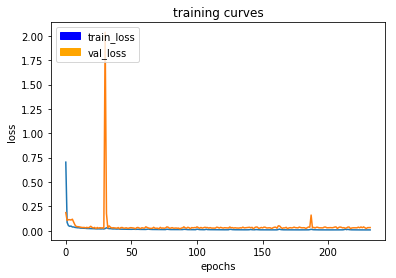

75/75 [==============================] - 137s - loss: 0.0077 - val_loss: 0.0318
Epoch 234/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

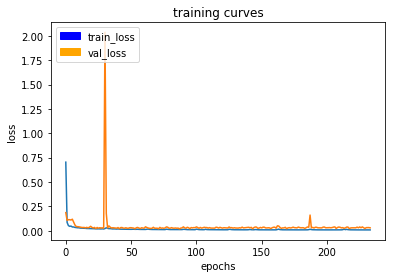

75/75 [==============================] - 138s - loss: 0.0077 - val_loss: 0.0289
Epoch 235/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

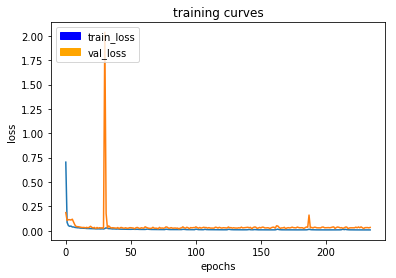

75/75 [==============================] - 137s - loss: 0.0077 - val_loss: 0.0332
Epoch 236/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

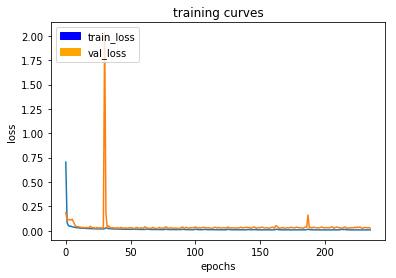

75/75 [==============================] - 137s - loss: 0.0077 - val_loss: 0.0250
Epoch 237/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

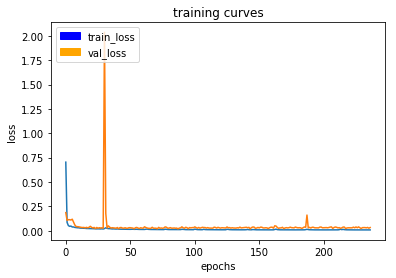

75/75 [==============================] - 136s - loss: 0.0077 - val_loss: 0.0321
Epoch 238/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

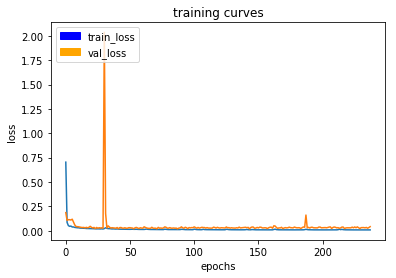

75/75 [==============================] - 137s - loss: 0.0077 - val_loss: 0.0409
Epoch 239/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

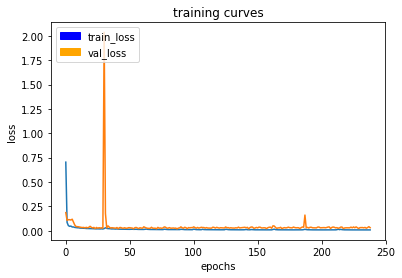

75/75 [==============================] - 138s - loss: 0.0078 - val_loss: 0.0304
Epoch 240/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

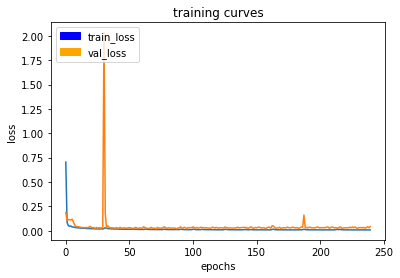

75/75 [==============================] - 137s - loss: 0.0077 - val_loss: 0.0423
Epoch 241/250
74/75 [============================>.] - ETA: 1s - loss: 0.0076

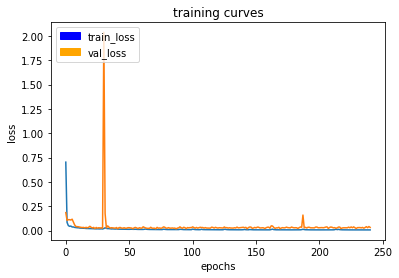

75/75 [==============================] - 137s - loss: 0.0076 - val_loss: 0.0334
Epoch 242/250
74/75 [============================>.] - ETA: 1s - loss: 0.0076

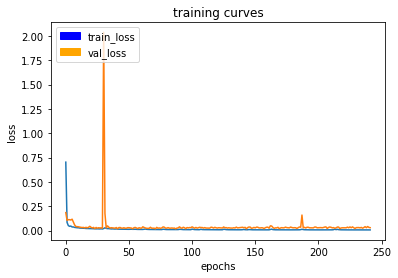

75/75 [==============================] - 137s - loss: 0.0076 - val_loss: 0.0306
Epoch 243/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

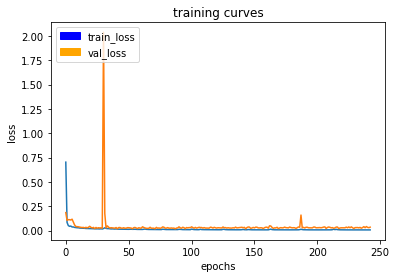

75/75 [==============================] - 138s - loss: 0.0077 - val_loss: 0.0359
Epoch 244/250
74/75 [============================>.] - ETA: 1s - loss: 0.0076

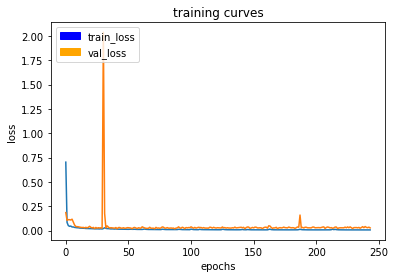

75/75 [==============================] - 137s - loss: 0.0076 - val_loss: 0.0282
Epoch 245/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

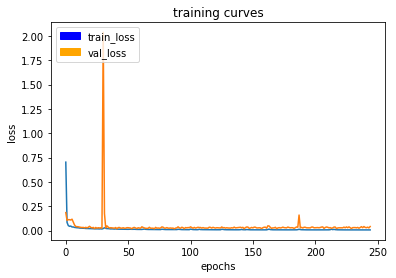

75/75 [==============================] - 138s - loss: 0.0077 - val_loss: 0.0420
Epoch 246/250
74/75 [============================>.] - ETA: 1s - loss: 0.0077

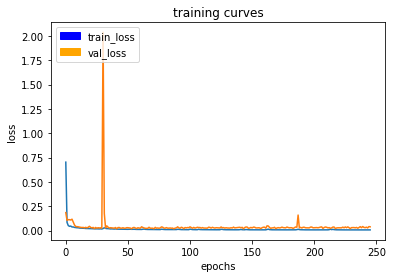

75/75 [==============================] - 137s - loss: 0.0077 - val_loss: 0.0394
Epoch 247/250
74/75 [============================>.] - ETA: 1s - loss: 0.0078

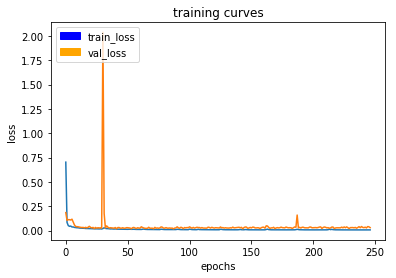

75/75 [==============================] - 137s - loss: 0.0078 - val_loss: 0.0311
Epoch 248/250
74/75 [============================>.] - ETA: 1s - loss: 0.0086

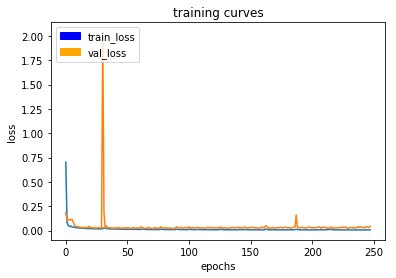

75/75 [==============================] - 139s - loss: 0.0087 - val_loss: 0.0441
Epoch 249/250
74/75 [============================>.] - ETA: 1s - loss: 0.0129

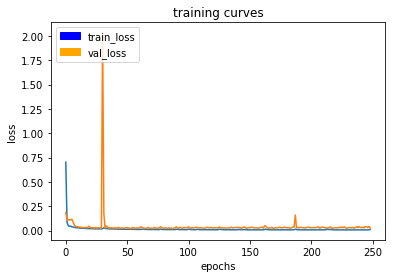

75/75 [==============================] - 137s - loss: 0.0128 - val_loss: 0.0276
Epoch 250/250
74/75 [============================>.] - ETA: 1s - loss: 0.0091

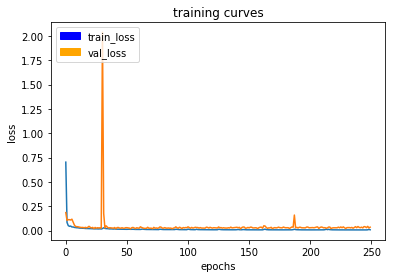

75/75 [==============================] - 137s - loss: 0.0091 - val_loss: 0.0359


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [2]:
# Save your trained model weights
weight_file_name = 'model_weights_003'
model_tools.save_network(model, weight_file_name)

NameError: name 'model' is not defined

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [3]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights.h5'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [4]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

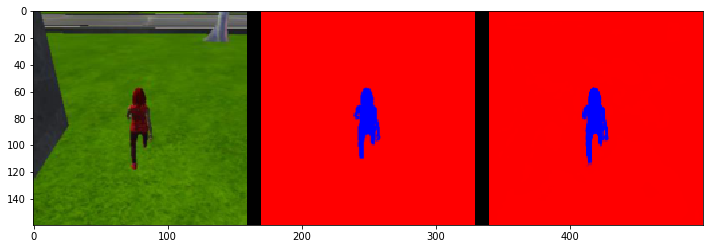

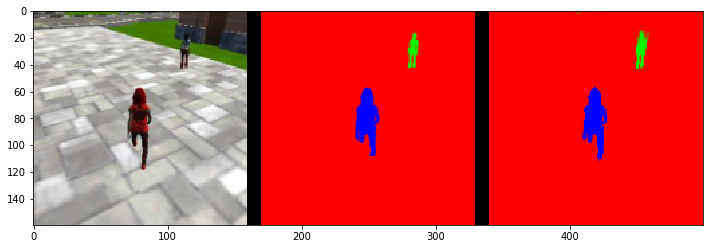

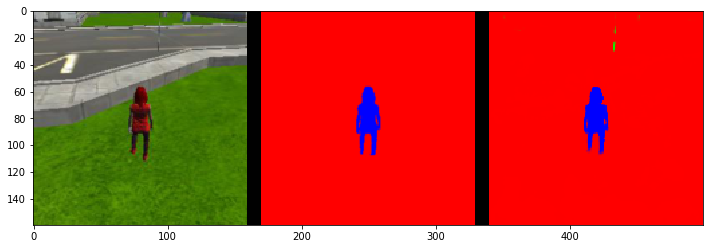

In [5]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

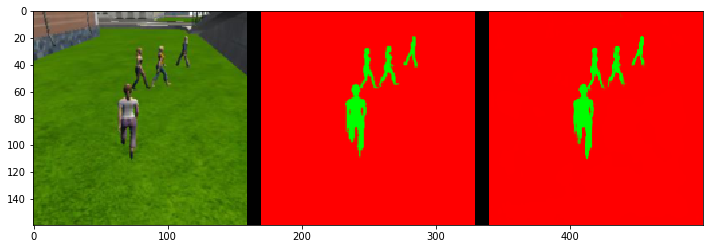

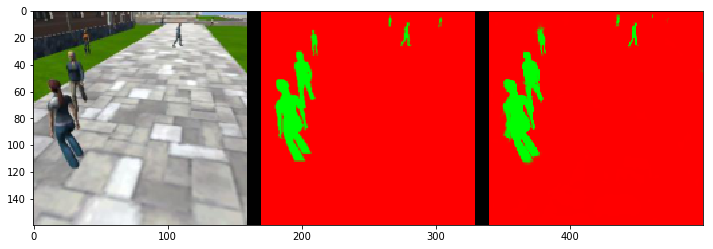

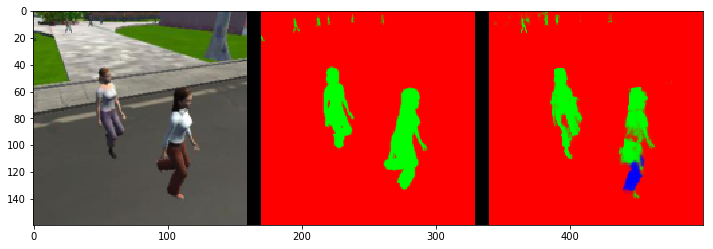

In [6]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

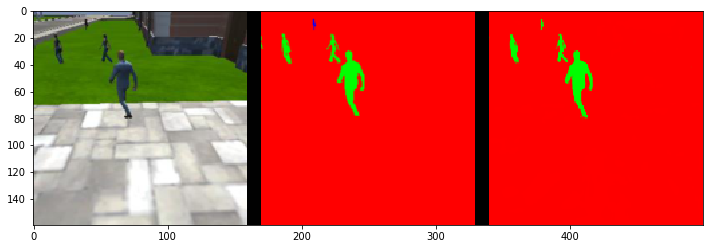

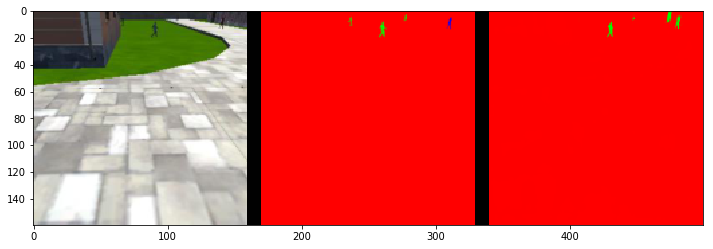

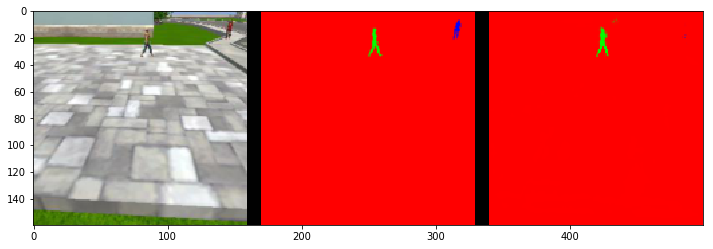

In [7]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [8]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9959554457508514
average intersection over union for other people is 0.40203133771400773
average intersection over union for the hero is 0.9317571320831315
number true positives: 539, number false positives: 0, number false negatives: 0


In [9]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9885822608903475
average intersection over union for other people is 0.7804215499483407
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 41, number false negatives: 0


In [10]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965804019650119
average intersection over union for other people is 0.48111062319485576
average intersection over union for the hero is 0.23272282345749454
number true positives: 114, number false positives: 2, number false negatives: 187


In [11]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.739524348810872


In [12]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.58223997777


In [13]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.430580640412
